In [1]:

import numpy as np
import os
import numpy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel, ConstantKernel as C
from scipy.spatial import cKDTree
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import plotly.graph_objects as go
import numpy as np
import plotly.io as pio
import plotly.express as px
from plotly.offline import init_notebook_mode
#pio.renderers.default = "browser"
# Enable inline display
init_notebook_mode(connected=True)



# Status 20 Nov
- Many of the candidates are maxed out due to grid resolution --> needs true gradient search, not gridding
- I have hacked local search around high points for a few of the functions.  Needs improvement on the following points
    - scaling is completely hacked - need to more systematically build scalers into my framework
- dimension reduction is super useful.  However...
    - it is hacked using the Transformation Strategy class 
    - it is not automatic, ie I need to manually look at most significant dimensions 

# TODO in December


## Overall algorithm
1. Globally fit a GP Posterior
2. 10000 random samples of the GP Posterior according to Sobol or Latin Hypercube
3. Choose top one and build trust region and optimize in that trust region via gradient search
    Propose point
    Display 5 nearest neighbors
    Display improvement vs. neighbors
    Display expected peak value

4. Choose next one that is not in previous trust region
    Propose point
    Display 5 nearest neighbors
    Display improvement vs. neighbors
    Display expected peak value

5. Continue to cover all top 5 points
6. Choose the one that maximizes local peak value (may later add a penalty for being too close to existing points)

## Code sanity
0. Auto-write the "latest" directory when new data is read in - almost burned me this week
1. Separate instantiation of a function object from loading from disk, ie
        a = BBfcn()
        a.loadFromDisk()
2. Auto-scale everything from 0 to 1 for Gaussian Process fitting then scale back, or keep in natural units and auto-determine kernel limits and length scales
3. Run an optimizer on the GP instead of gridding - will help with gridding slow-down and resolution issues
4. Extend BBfcn class to allow it to keep track of 
    - scalers
    - kernels (which should be automatic but can be overridden via a strategy method)
    - trust regions and submodels and book keeping among them
    - reduced dimension models
5. Find a way to make dimension reduction automatic, ie rank most signfiicant dimensions automatically and store reduced dimension model in main class

Class hierarchy might look like this

BBOfcn
    - Run BO and plot
    - Keep track of scalers
    - allow Transformers to be registered
    - plot correlations
    - reduce dimensionality
    - initialize empty, from disk, or from an existing BBOfcn

    + --------- TopBBOfcn
        - keep track of sub models
        - arbitrate between submodels
        - Consolidate and display proposal from submodels


## More speculative work
1. Pull code from Optimus team and see if I can run it and use it
2. Read 2029 Turbo paper


In [2]:
## Helper function

''' Converts black box functions from np.arrays to pandas.DataFrames for easier interpretation of tabular data
Inputs:
    npa_x       inputs x1,x2,... as np array
    npa_y       output y as np array

Outputs:
    df          Dataframe with columns x1, x2, ... and y
'''

def fcn_as_df(npa_x,npa_y):
    # assure that even single rows have two dimensions - avoids breaking code below
    if npa_x.ndim == 1:
        npa_x = npa_x.reshape(1,-1)
        npa_y = npa_y.reshape(1,-1)

    n_col = npa_x.shape[1]
    col_names = [f"x{i+1}" for i in range(n_col)]
    df = pd.DataFrame(npa_x,columns=col_names)
    df["y"] = np.ravel(npa_y).T
    return df

''' Helper - Reads numpy arrays for each of the eight functions from disk and returns a list of dataframes containing the input and output info

Inputs: 
    path_to_fcns    Directory path - must contain folders "function_1","function_2"... each containing inputs.npy and outputs.npy 

Outputs: 
    fcn_dict - Dictionary of dataframes for each function, each dataframe containing columns x1, x2,..., y
'''


def read_fcns_from_disk(path_to_fcns):
    f_in = []
    f_out = []
    num_functions = 8
    # read the functions as a list of numpy arrays, separate for inputs x and output y
    for i in range(0, num_functions):
        dir_path = os.path.join(path_to_fcns, f'function_{i+1}')
        inputs = np.load(os.path.join(dir_path, 'inputs.npy'))
        outputs = np.load(os.path.join(dir_path, 'outputs.npy'))
        f_in.append(inputs)
        f_out.append(outputs)
        
    # create a dictionary of form {"f_1": DataFrame, "f_2": DataFrame, } where the DataFrames have column names x1, x2, ..., y
    fcn_dict = {}
    for i in range(0, num_functions):
        npa_x = f_in[i]
        npa_y = f_out[i]

        fcn_dict[f"f_{i+1}"] = fcn_as_df(npa_x,npa_y)

    return fcn_dict




In [3]:
# Helper function to print query point in expected format

def format_query(queryPoint):
    
    print(f"queryPoint={queryPoint}")

    # print the elements of the vector queryPoint, in the format 0.000000-0.000000-0.000000
    # where there is one 0.000000 per element in the vector

    query_str = '-'.join([f"{elem:.6f}" for elem in np.ravel(queryPoint)])
    print(f"queryPoint (formatted)={query_str}")

    #query_str=""
    #query_str.join(f"{queryPoint[0]:.6f}")
    #query_str.join([f"{elem:.6f}" for elem in np.ravel(queryPoint[1:])])
    #print(f"queryPoint (formatted)={query_str}")

# Helper Class for data transformations
Abstract class to allow users to apply transformations to the original data such as
- outlier imputation
- coordinate transformations

They can apply a transformation to a function by implementing this interface and invoking the transformation with the .transform() method of BBfcn

In [4]:
from abc import ABC, abstractmethod

class Transformation(ABC):
    @abstractmethod
    def apply(self,data):
        pass

# Main data structure - BBfcn (Black Box Function)
- Contains all known data points of the black box function as read from the directory /measurements/latest
- Implements methods to fit surrogate functions, grid acquisition functions, make graphs, estimate correlation coefficients, etc.


In [5]:
import itertools

class BBfcn:

    latest_data_dir = os.path.join(".","measurements","latest")

    def __init__(self,function_number):
        self.function_number = function_number
        self.function_name = f"function_{function_number}"
        self.data_dir = os.path.join(self.latest_data_dir,self.function_name)
        self.__inputs = np.load(os.path.join(self.data_dir, 'inputs.npy'))
        self.__outputs = np.load(os.path.join(self.data_dir, 'outputs.npy'))
        self.data = fcn_as_df(self.__inputs,self.__outputs)
        self.update()

    # display the function
    def __str__(self):
        print(f"------------ {self.function_name} --------------")
        print(self.data)
        print(f"\nMax of {self.max} realized at row")
        print(self.argmax)
        return ""
    
    # update internal statistics after data modification
    def update(self):
        self.max = self.data["y"].max()
        self.argmax = self.data.loc[[self.data["y"].idxmax()]]
        self.input_dimension = self.data.shape[1]-1


    # API to allow user to apply a transformation or otherwise modify the data
    # they must implement tr, an instance of Transformation, including implementing mandatory method Transformation.apply()
    def transform(self, tr: Transformation):
        self._orig_data = self.data.copy()
        tr.apply(self.data) # pass the user the data for in-place modification. This should be the only way to modify the data
        self.update()
        
    def plot_feature_correlations(self):
        """
        Plot correlations between features and with target.
        """
        # 3. Pairwise scatterplots
        sns.pairplot(self.data)
        plt.show()

        # 1. Correlation matrix of features
        X_df = self.data.drop("y",axis=1).copy()
        #corr_matrix = X_df.corr()
        #plt.figure(figsize=(10, 8))
        #sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
        #plt.title("Feature Correlation Matrix")
        #plt.show()
    
        # 2. Correlation with target
        corr_with_target = X_df.corrwith(self.data["y"])
        plt.figure(figsize=(10, 5))
        sns.barplot(x=corr_with_target.index, y=corr_with_target.values)
        plt.xticks(rotation=45)
        plt.ylabel("Correlation with Target")
        plt.title("Feature Correlation with Target")
        plt.show()

    def plot_correlations_with_cross_terms(self):
        df = self.data.copy()
    
        # original feature columns
        feature_cols = df.columns[:-1]
    
        # Generate all pairwise cross terms
        for col1, col2 in itertools.combinations(feature_cols, 2):
            cross_col_name = f'{col1}*{col2}'
            df[cross_col_name] = df[col1] * df[col2]
    
        # Compute correlation of each column with the target
        corr_with_target = df.corr()["y"].sort_values(ascending=False)
    
        # Plot
        plt.figure(figsize=(10, max(4, len(corr_with_target)/2)))
        sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
        plt.title(f'Correlation of features with target')
        plt.xlabel('Correlation')
        plt.ylabel('Feature')
        plt.show()

    def ucb(self,X_candidate, gp, kappa=2.0):
        mu, sigma = gp.predict(X_candidate, return_std=True)
        return mu + kappa * sigma

    def nextPointBayesianOptim(self,kernel,numgrid=20,acqFcn="UCB",beta=0.5):
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15, normalize_y=True)
        y_train = self.data.iloc[:,-1].to_numpy()  # output is in last column
        X_train = self.data.iloc[:,:-1].to_numpy() # other columns are inputs 
        gp.fit(X_train, y_train)
        print("GP kernel=")
        print(gp.kernel)
        #kernel_params = gp.kernel_.get_params()
        #print(kernel_params["k2__length_scale"])     # Access Matern length scale

        x = []
        for i in range(self.input_dimension):
            x.append(np.linspace(0,1,numgrid))

        xvalue_grids = np.meshgrid(*x,indexing="ij")
        flat = [g.reshape(-1) for g in xvalue_grids]
        X_for_gp = np.vstack(flat).T
        
        # Acquisition function      
        mu, sigma = gp.predict(X_for_gp, return_std=True)
        ucb = mu + beta * sigma

        # Select next acquisition point ---
        next_idx = np.argmax(ucb)
        X_next = X_for_gp[next_idx]
        print("Next acquisition point (UCB):", X_next)
        format_query(X_next)

        # Interactive plot for 2D
        if self.input_dimension == 2:
            y_GP = mu.reshape(xvalue_grids[0].shape)
            dimension_names = self.data.columns[:-1].tolist()
            # Mean of Gaussian Process
            fig = go.Figure(data=[go.Surface(z=y_GP, x=xvalue_grids[0], y=xvalue_grids[1], opacity=0.4)])
            fig.update_layout(scene=dict(
                xaxis_title=dimension_names[0],
                yaxis_title=dimension_names[1],
                zaxis_title=f'f({dimension_names[0]},{dimension_names[1]})'))
            # original data points
            fig.add_trace(go.Scatter3d(
                x=X_train[:, 0],
                y=X_train[:, 1],
                z=y_train,
                mode='markers',
                marker=dict(color='red', size=5),
                name='Measured points'))
            fig.show()
        return X_next

    # Farthest Point Sampling
    def FPS(self):
        X_train = self.data.iloc[:,:-1].to_numpy() # last column is the target
        tree = cKDTree(X_train)
        num_candidates = 10000
        num_candidates_per_dim = int(np.ceil(num_candidates ** (1 / self.input_dimension))) 
        x = []
        for i in range(self.input_dimension):
            x.append(np.linspace(0,1,num_candidates_per_dim))
        xvalue_grids = np.meshgrid(*x,indexing="ij")
        flat = [g.reshape(-1) for g in xvalue_grids]
        X_candidates = np.vstack(flat).T

        distances, _ = tree.query(X_candidates, k=1)
        # Sort the grid points by descending distance
        idx_sorted = np.argsort(-distances)
        N = 4
        unexplored_points = X_candidates[idx_sorted[:N]] #magic number 4 - pick top 4 most unexplored points
        farthest_idx = np.argmax(distances)
        X_next = X_candidates[farthest_idx]
        # Optional: print or visualize
        print("Most unexplored points (farthest from training data):")
        print(unexplored_points)
        print("point this week according to FPS:", unexplored_points[0,:])      

        # Interactive plot for 2D
        if self.input_dimension == 2:
            dimension_names = self.data.columns[:-1].tolist()
            fig = go.Figure()
            # original data points
            fig.add_trace(go.Scatter3d(
                x=X_train[:, 0],
                y=X_train[:, 1],
                z=self.data.iloc[:,-1].to_numpy(),
                mode='markers',
                marker=dict(color='red', size=3),
                name='Measured points'))
            # candidate points colored by distance to nearest existing point
            fig.add_trace(go.Scatter3d(
                x=X_candidates[:N, 0],
                y=X_candidates[:N, 1],
                z=np.zeros(N),
                mode='markers',
                marker=dict(
                    size=7,
                    color=distances,
                    colorscale='Viridis',
                    colorbar=dict(title='Distance to Nearest Point'),
                ),
                name='Candidate points'))
            fig.update_layout(scene=dict(
                xaxis_title=dimension_names[0],
                yaxis_title=dimension_names[1],
                zaxis_title='Distance to Nearest Point'))
            fig.show()
        


# Function 01
Week 6 notes
- global model kept flattening out
- hacked a local model (needs cleanup, especially around handling of scaling)
- set beta = 0
- set grid to 100 - needs optimizer
- need to plot local model in original coordinates, not transformed coordinates




BEFORE DATA TRANSFORMATION
---
------------ function_1 --------------
       x1     x2           y
0   0.319  0.763   1.323e-79
1   0.574  0.880   1.033e-46
2   0.731  0.733   7.711e-16
3   0.840  0.265  3.342e-124
4   0.650  0.682  -3.606e-03
5   0.410  0.148  -2.159e-54
6   0.313  0.079  -2.089e-91
7   0.683  0.861   2.535e-40
8   0.083  0.403   3.607e-81
9   0.884  0.582   6.230e-48
10  0.997  1.000  3.216e-191
11  0.653  0.204   5.750e-71
12  0.000  1.000   0.000e+00
13  0.000  0.735 -1.009e-192
14  0.653  1.000  -3.699e-97
15  0.737  1.000  4.569e-105
16  0.731  0.582   5.955e-10

Max of 5.955489641096722e-10 realized at row
       x1     x2          y
16  0.731  0.582  5.955e-10



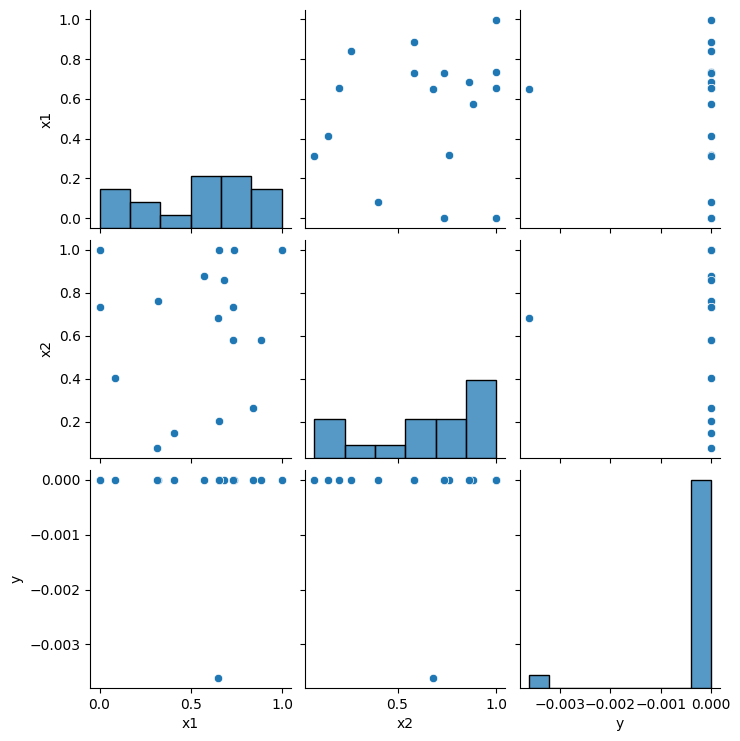

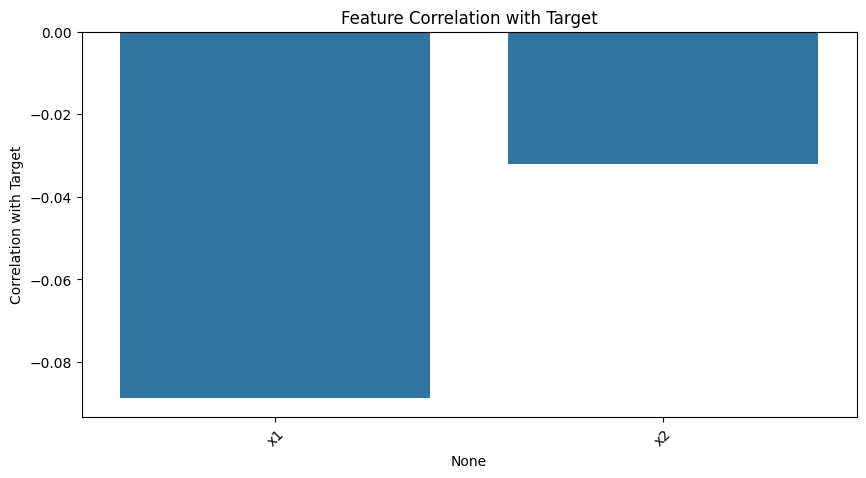

AFTER DATA TRANSFORMATION
---
------------ function_1 --------------
       x1     x2      y
0   0.319  0.763  0.000
1   0.574  0.880  0.098
2   0.731  0.733  0.856
3   0.840  0.265  0.000
4   0.650  0.682  0.000
5   0.410  0.148  0.000
6   0.313  0.079  0.000
7   0.683  0.861  0.255
8   0.083  0.403  0.000
9   0.884  0.582  0.069
10  0.997  1.000  0.000
11  0.653  0.204  0.000
12  0.000  1.000  0.000
13  0.000  0.735  0.000
14  0.653  1.000  0.000
15  0.737  1.000  0.000
16  0.731  0.582  1.000

Max of 1.0 realized at row
       x1     x2    y
16  0.731  0.582  1.0



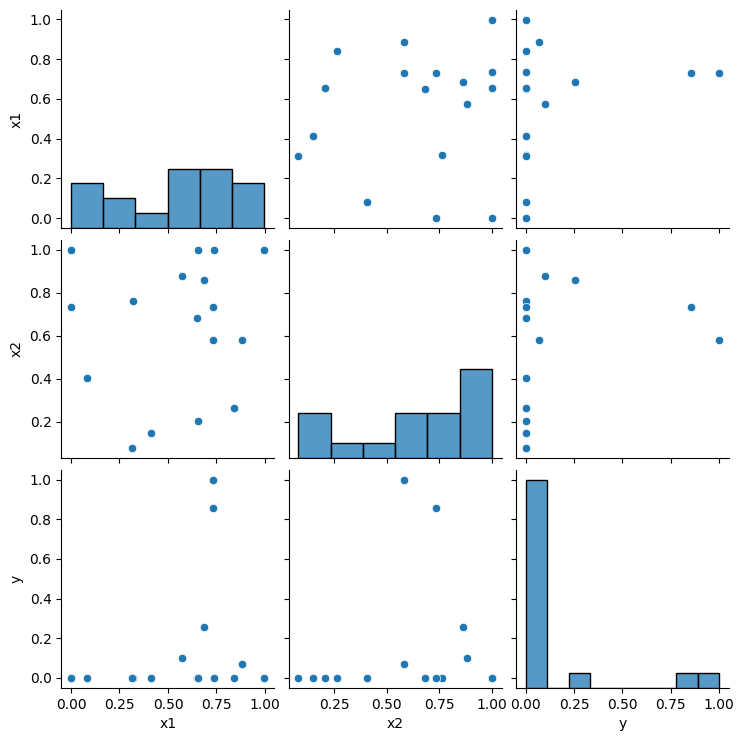

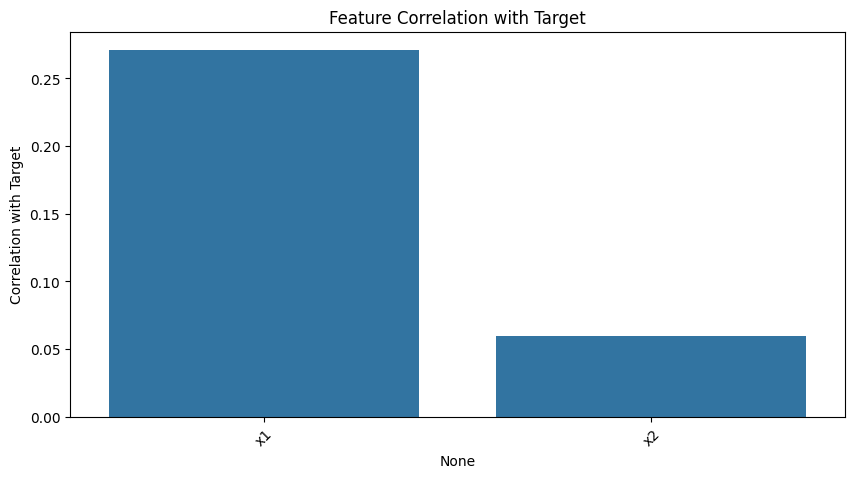

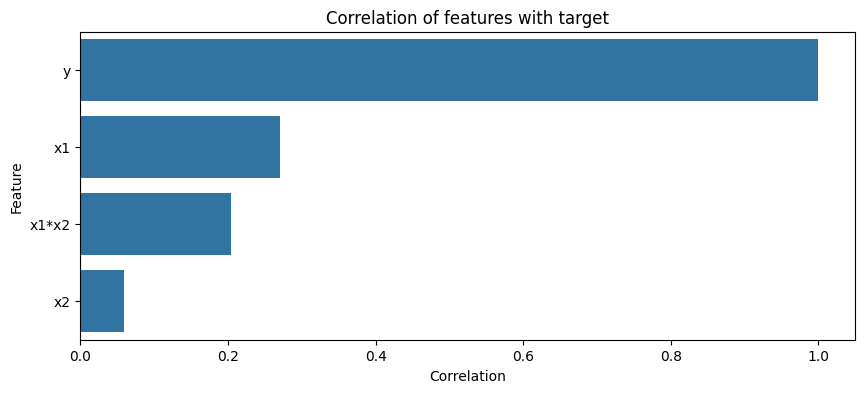

/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:305: RuntimeWarning:

divide by zero encountered in log



GP kernel=
3.16**2 * Matern(length_scale=[0.05, 0.05], nu=0.1) + WhiteKernel(noise_level=0)
Next acquisition point (UCB): [0.68421053 0.84210526]
queryPoint=[0.68421053 0.84210526]
queryPoint (formatted)=0.684211-0.842105


/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning:

The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.



Most unexplored points (farthest from training data):
[[0.         0.        ]
 [0.         0.01010101]
 [0.         0.02020202]
 [0.         0.03030303]]
point this week according to FPS: [0. 0.]


/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:305: RuntimeWarning:

divide by zero encountered in log

/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.



TRUST REGION AROUND CURRENT MAX
---
------------ function_1 --------------
       x1         x2      y
2   0.346  1.000e+00  0.856
4   0.000  6.585e-01  0.000
9   1.000  0.000e+00  0.069
16  0.345  1.699e-07  1.000

Max of 1.0 realized at row
       x1         x2    y
16  0.345  1.699e-07  1.0

GP kernel=
1**2 * Matern(length_scale=[0.5, 0.5], nu=0.5) + WhiteKernel(noise_level=0)
Next acquisition point (UCB): [0.34343434 0.        ]
queryPoint=[0.34343434 0.        ]
queryPoint (formatted)=0.343434-0.000000


Next acquisition point in original scale: (array([[0.73040069]]), array([[0.58225397]]))
queryPoint=[[[[0.73040069]]

  [[0.58225397]]]]
queryPoint (formatted)=0.730401-0.582254


In [6]:
#pd.set_option('display.float_format', '{:.2g}'.format)
#pd.reset_option('display.float_format')
pd.set_option("display.precision",3)

f1 = BBfcn(1)
print("BEFORE DATA TRANSFORMATION")
print("---")
print(f1)
f1.plot_feature_correlations()

print("AFTER DATA TRANSFORMATION")
print("---")
# Customer strategy for f1() to remove negative values and take log of y
class f1_scale_and_outliers(Transformation):    
    def apply(self,data):
        self.substitute_val_for_small_values = 1e-50
        data.loc[data["y"]<1e-70,"y"] = self.substitute_val_for_small_values
        data["y"] = np.log10(data["y"])
        scaler = MinMaxScaler(feature_range=(0, 1))
        data["y"] = scaler.fit_transform(data[["y"]])
        #data.drop(data.tail(4).index, inplace=True)


tr = f1_scale_and_outliers()
f1.transform(tr)
print(f1)
f1.plot_feature_correlations()
f1.plot_correlations_with_cross_terms()
#kernel = C(1, (1e-5, 10)) * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=0.01)
kernel = C(10, (0.001, 10)) * Matern(length_scale=[0.05,0.05],nu=0.1) + WhiteKernel(noise_level=0.0)
f1.nextPointBayesianOptim(kernel,numgrid=20,acqFcn="UCB",beta=0.5)
f1.FPS()

# hack to try creating a trust region around the current max
f1_trust = BBfcn(1) # we should not need to re-load the data, but for now do so to reset to original data
class f1_trust_region(Transformation):
    def apply(self,data):
        # keep only points within 0.2 of the current max in each dimension
        row_of_max = data["y"].idxmax()
        max_point = data.iloc[row_of_max,:-1].to_numpy()
        for i, col in enumerate(data.columns[:-1]):
            lower_bound = max(0.0, max_point[i] - 0.2)
            upper_bound = min(1.0, max_point[i] + 0.2)
            data.drop(data[(data[col] < lower_bound) | (data[col] > upper_bound)].index, inplace=True)

        self.substitute_val_for_small_values = 1e-50
        data.loc[data["y"]<1e-70,"y"] = self.substitute_val_for_small_values
        data["y"] = np.log10(data["y"])
        scalerY = MinMaxScaler(feature_range=(0, 1))
        data["y"] = scalerY.fit_transform(data[["y"]])
        scalerX1 = MinMaxScaler(feature_range=(0, 1))
        data["x1"] = scalerX1.fit_transform(data[["x1"]])
        scalerX2 = MinMaxScaler(feature_range=(0, 1))
        data["x2"] = scalerX2.fit_transform(data[["x2"]])
        self.scalers = [scalerX1, scalerX2, scalerY]

tr_trust = f1_trust_region()
f1_trust.transform(tr_trust)
print("TRUST REGION AROUND CURRENT MAX")
print("---")
print(f1_trust)
kernel = C(1, (0.00001, 10)) * Matern(length_scale=[0.5,0.5],nu=0.5) + WhiteKernel(noise_level=0.0)
X_next = f1_trust.nextPointBayesianOptim(kernel,numgrid=100,acqFcn="UCB",beta=0.5)
# need to inverse transform X_next to original scale
x1_orig = tr_trust.scalers[0].inverse_transform(X_next[0].reshape(1,-1))
x2_orig = tr_trust.scalers[1].inverse_transform(X_next[1].reshape(1,-1))
print("Next acquisition point in original scale:", (x1_orig, x2_orig))
format_query(np.array([[x1_orig, x2_orig]]))    



# Function 02
Week 6 notes
- hacked a local model around max (needs cleanup, especially around handling of scaling)
- set beta = 0

Also needs optimizer
Need to display local model in original coordinates, not transformrd coordinates


In [7]:
f2 = BBfcn(2)
print(f2)

# f2.plot_feature_correlations()
# f2.plot_correlations_with_cross_terms()
kernel = C(10, (0.001, 10)) * Matern(length_scale=[1,1],nu=2.5) + WhiteKernel(noise_level=0.2)
f2.nextPointBayesianOptim(kernel,numgrid=20,acqFcn="UCB",beta=0.5)
f2.FPS()


# hack to try creating a trust region around the current max
f2_trust = BBfcn(2) # we should not need to re-load the data, but for now do so to reset to original data
class f2_trust_region(Transformation):
    def apply(self,data):
        # keep only points within 0.15 of the current max in each dimension
        row_of_max = data["y"].idxmax()
        max_point = data.loc[row_of_max].drop("y").to_numpy()
        for i, col in enumerate(data.columns[:-1]):
            lower_bound = max(0.0, max_point[i] - 0.2)
            upper_bound = min(1.0, max_point[i] + 0.2)
            data.drop(data[(data[col] < lower_bound) | (data[col] > upper_bound)].index, inplace=True)

        scalerY = MinMaxScaler(feature_range=(0, 1))
        data["y"] = scalerY.fit_transform(data[["y"]])
        scalerX1 = MinMaxScaler(feature_range=(0, 1))
        data["x1"] = scalerX1.fit_transform(data[["x1"]])
        scalerX2 = MinMaxScaler(feature_range=(0, 1))
        data["x2"] = scalerX2.fit_transform(data[["x2"]])
        self.scalers = [scalerX1, scalerX2, scalerY]

tr_trust2 = f2_trust_region()
f2_trust.transform(tr_trust2)
print("TRUST REGION AROUND CURRENT MAX")
print("---")
print(f2_trust)
kernel = C(1, (0.00001, 10)) * Matern(length_scale=[0.5,0.5],nu=0.5) + WhiteKernel(noise_level=0.0)
X_next = f2_trust.nextPointBayesianOptim(kernel,numgrid=50,acqFcn="UCB",beta=0)
# need to inverse transform X_next to original scale
x1_orig = tr_trust2.scalers[0].inverse_transform(X_next[0].reshape(1,-1))
x2_orig = tr_trust2.scalers[1].inverse_transform(X_next[1].reshape(1,-1))
print("Next acquisition point in original scale:", (x1_orig, x2_orig))
format_query(np.array([[x1_orig, x2_orig]]))   


------------ function_2 --------------
       x1     x2      y
0   0.666  0.124  0.539
1   0.878  0.779  0.421
2   0.143  0.349 -0.066
3   0.845  0.711  0.294
4   0.455  0.290  0.215
5   0.578  0.772  0.023
6   0.438  0.685  0.245
7   0.342  0.029  0.039
8   0.339  0.214 -0.014
9   0.703  0.927  0.611
10  0.758  1.000  0.241
11  0.000  0.000 -0.009
12  0.000  1.000 -0.138
13  0.694  0.755  0.552
14  0.694  0.755  0.646
15  0.684  1.000  0.617
16  0.700  0.887  0.613

Max of 0.6458577203776756 realized at row
       x1     x2      y
14  0.694  0.755  0.646

GP kernel=
3.16**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=0.2)
Next acquisition point (UCB): [0.68421053 1.        ]
queryPoint=[0.68421053 1.        ]
queryPoint (formatted)=0.684211-1.000000


Most unexplored points (farthest from training data):
[[1.         0.34343434]
 [1.         0.33333333]
 [0.98989899 0.34343434]
 [1.         0.35353535]]
point this week according to FPS: [1.         0.34343434]


TRUST REGION AROUND CURRENT MAX
---
------------ function_2 --------------
       x1     x2      y
1   1.000  0.313  0.638
3   0.892  0.000  0.435
5   0.000  0.282  0.000
9   0.416  1.000  0.944
13  0.387  0.204  0.848
14  0.387  0.204  1.000
16  0.408  0.816  0.947

Max of 1.0 realized at row
       x1     x2    y
14  0.387  0.204  1.0

GP kernel=
1**2 * Matern(length_scale=[0.5, 0.5], nu=0.5) + WhiteKernel(noise_level=0)
Next acquisition point (UCB): [0.40816327 0.81632653]
queryPoint=[0.40816327 0.81632653]
queryPoint (formatted)=0.408163-0.816327


/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:305: RuntimeWarning:

divide by zero encountered in log

/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning:

The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.



Next acquisition point in original scale: (array([[0.70019372]]), array([[0.88699286]]))
queryPoint=[[[[0.70019372]]

  [[0.88699286]]]]
queryPoint (formatted)=0.700194-0.886993


------------ function_3 --------------
       x1     x2     x3      y
0   0.172  0.344  0.249 -0.112
1   0.242  0.644  0.272 -0.088
2   0.535  0.399  0.173 -0.111
3   0.493  0.612  0.340 -0.035
4   0.135  0.220  0.458 -0.048
5   0.346  0.941  0.269 -0.111
6   0.152  0.440  0.991 -0.399
7   0.646  0.397  0.920 -0.114
8   0.747  0.284  0.226 -0.131
9   0.170  0.697  0.149 -0.094
10  0.221  0.298  0.344 -0.047
11  0.666  0.672  0.246 -0.106
12  0.047  0.231  0.771 -0.118
13  0.600  0.725  0.066 -0.036
14  0.966  0.861  0.567 -0.057
15  0.805  1.000  0.556 -0.065
16  0.000  0.000  0.000 -0.184
17  0.000  1.000  0.776 -0.131
18  0.000  0.000  0.653 -0.172
19  1.000  0.000  0.673 -0.195
20  1.000  1.000  0.421 -0.047
21  1.000  1.000  0.368 -0.062

Max of -0.034835313350078584 realized at row
      x1     x2    x3      y
3  0.493  0.612  0.34 -0.035



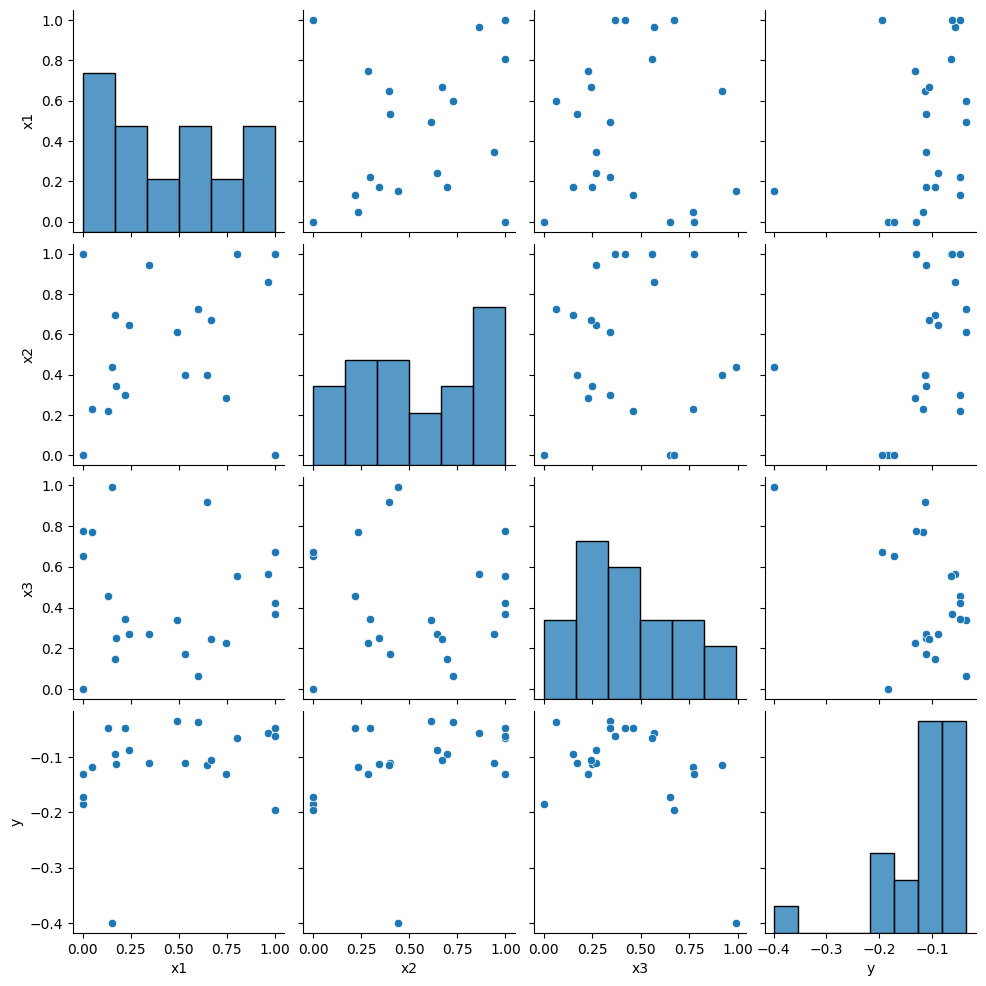

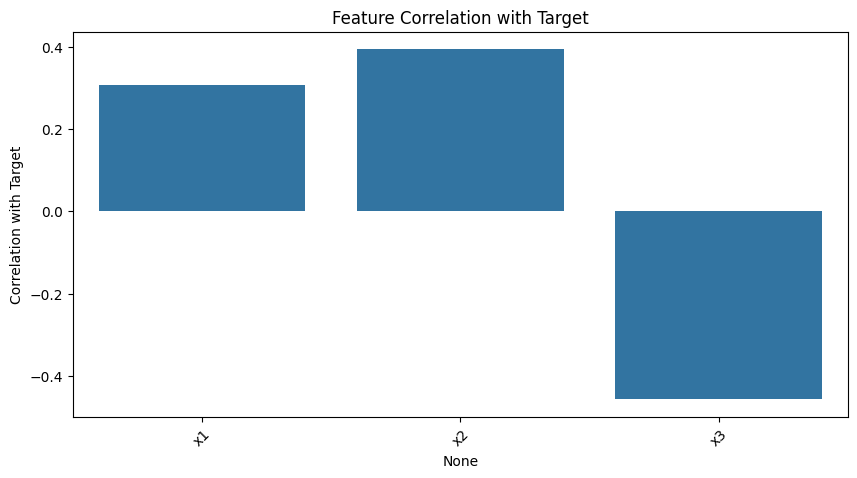

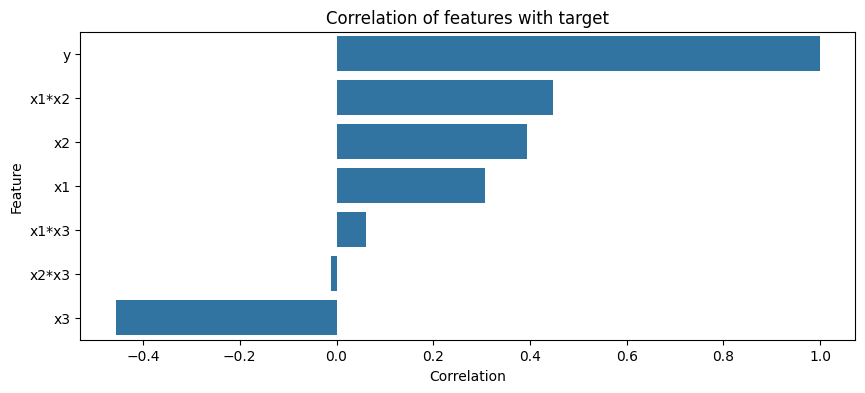

In [8]:
f3 = BBfcn(3)
print(f3)
f3.plot_feature_correlations()
f3.plot_correlations_with_cross_terms()

# Function 03

- standard Bayesian with beta = 0 gave something new
- seems dominated by x3
- ran dimension reduction to keep only x2 and x3
            - Kept x2 and x3
            - Treated x1 as "noise"
- no local model yet

Would benefit from maxing out current max and then exploring

------------ function_3 --------------
       x2     x3      y
0   0.344  0.249 -0.112
1   0.644  0.272 -0.088
2   0.399  0.173 -0.111
3   0.612  0.340 -0.035
4   0.220  0.458 -0.048
5   0.941  0.269 -0.111
6   0.440  0.991 -0.399
7   0.397  0.920 -0.114
8   0.284  0.226 -0.131
9   0.697  0.149 -0.094
10  0.298  0.344 -0.047
11  0.672  0.246 -0.106
12  0.231  0.771 -0.118
13  0.725  0.066 -0.036
14  0.861  0.567 -0.057
15  1.000  0.556 -0.065
16  0.000  0.000 -0.184
17  1.000  0.776 -0.131
18  0.000  0.653 -0.172
19  0.000  0.673 -0.195
20  1.000  0.421 -0.047
21  1.000  0.368 -0.062

Max of -0.034835313350078584 realized at row
      x2    x3      y
3  0.612  0.34 -0.035



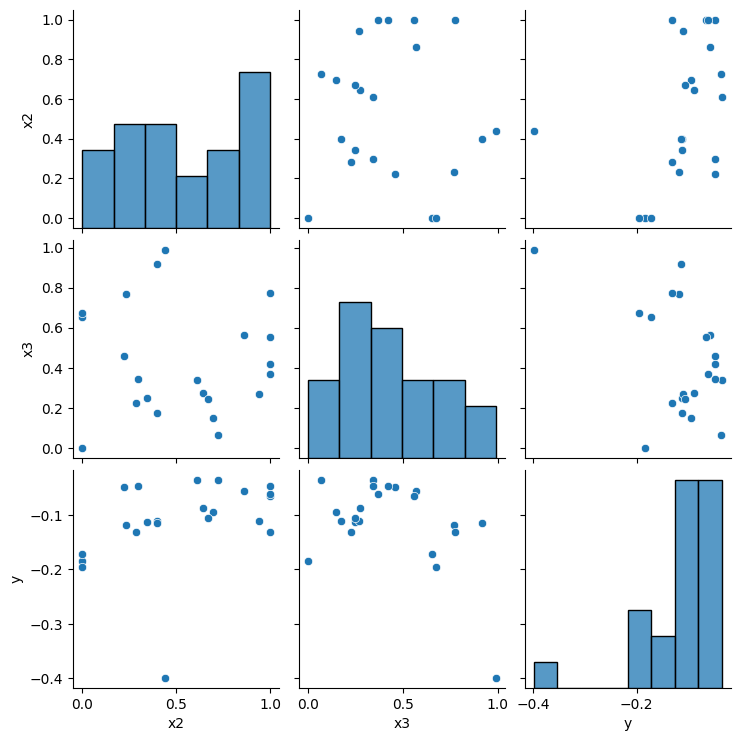

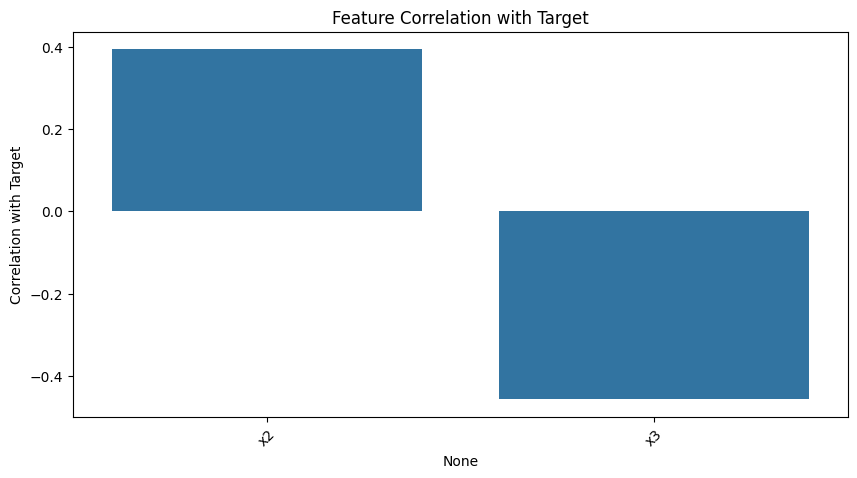

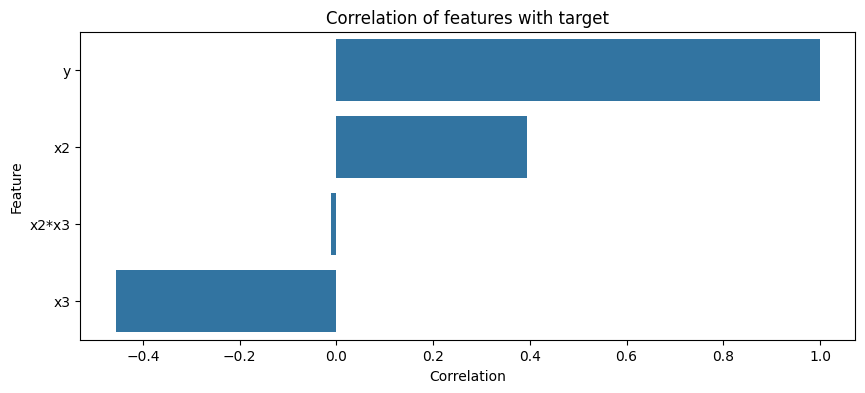

GP kernel=
3.16**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=0.1)
Next acquisition point (UCB): [0.         0.10526316]
queryPoint=[0.         0.10526316]
queryPoint (formatted)=0.000000-0.105263


/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.



GP kernel=
3.16**2 * Matern(length_scale=[1, 1, 1], nu=2.5) + WhiteKernel(noise_level=0.1)
Next acquisition point (UCB): [1.         1.         0.10526316]
queryPoint=[1.         1.         0.10526316]
queryPoint (formatted)=1.000000-1.000000-0.105263


/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.



array([1.        , 1.        , 0.10526316])

In [9]:
f3_dimRed = BBfcn(3)

# strategy class for f3() to reduce dimension by removing x1
class f3dimRedTransform(Transformation):
    def __init__(self):
        pass
    def apply(self,data):
        data.drop(columns=["x1"],inplace=True)

tr = f3dimRedTransform()
f3_dimRed.transform(tr)
print(f3_dimRed)
f3_dimRed.plot_feature_correlations()
f3_dimRed.plot_correlations_with_cross_terms()
kernel = C(10, (0.001, 10)) * Matern(length_scale=[1,1],nu=2.5) + WhiteKernel(noise_level=0.1)
f3_dimRed.nextPointBayesianOptim(kernel,numgrid=20,acqFcn="UCB",beta=0.5)

kernel = C(10, (0.001, 10)) * Matern(length_scale=[1,1,1],nu=2.5) + WhiteKernel(noise_level=0.1)
f3.nextPointBayesianOptim(kernel,numgrid=20,acqFcn="UCB",beta=0)

# Function 04

- standard Bayesian with beta = 0 and finer grid gave something new
- ran dimension reduction -- need to make this automatically update
- Nice clear max in x2, x3 space
- would benefit from gradient search and local model because secondary variables x1 and x4 are still significant


------------ function_4 --------------
       x1     x2     x3     x4       y
0   0.897  0.726  0.175  0.702 -22.108
1   0.889  0.500  0.539  0.509 -14.601
2   0.251  0.034  0.145  0.495 -11.700
3   0.347  0.006  0.761  0.613 -16.054
4   0.125  0.130  0.384  0.287 -10.070
5   0.801  0.500  0.707  0.195 -15.487
6   0.248  0.060  0.042  0.441 -12.682
7   0.747  0.757  0.369  0.207 -16.026
8   0.401  0.073  0.887  0.244 -17.049
9   0.626  0.587  0.439  0.779 -12.742
10  0.957  0.598  0.766  0.776 -27.316
11  0.733  0.145  0.477  0.133 -13.528
12  0.655  0.072  0.687  0.082 -16.679
13  0.220  0.832  0.483  0.083 -16.507
14  0.489  0.212  0.939  0.376 -17.818
15  0.167  0.877  0.217  0.960 -26.562
16  0.217  0.166  0.241  0.770 -12.758
17  0.387  0.805  0.752  0.724 -19.442
18  0.986  0.667  0.157  0.857 -28.903
19  0.038  0.665  0.162  0.254 -13.703
20  0.683  0.903  0.335  0.999 -29.427
21  0.170  0.757  0.277  0.531 -11.566
22  0.860  0.920  0.206  0.098 -26.858
23  0.282  0.506  0.531  

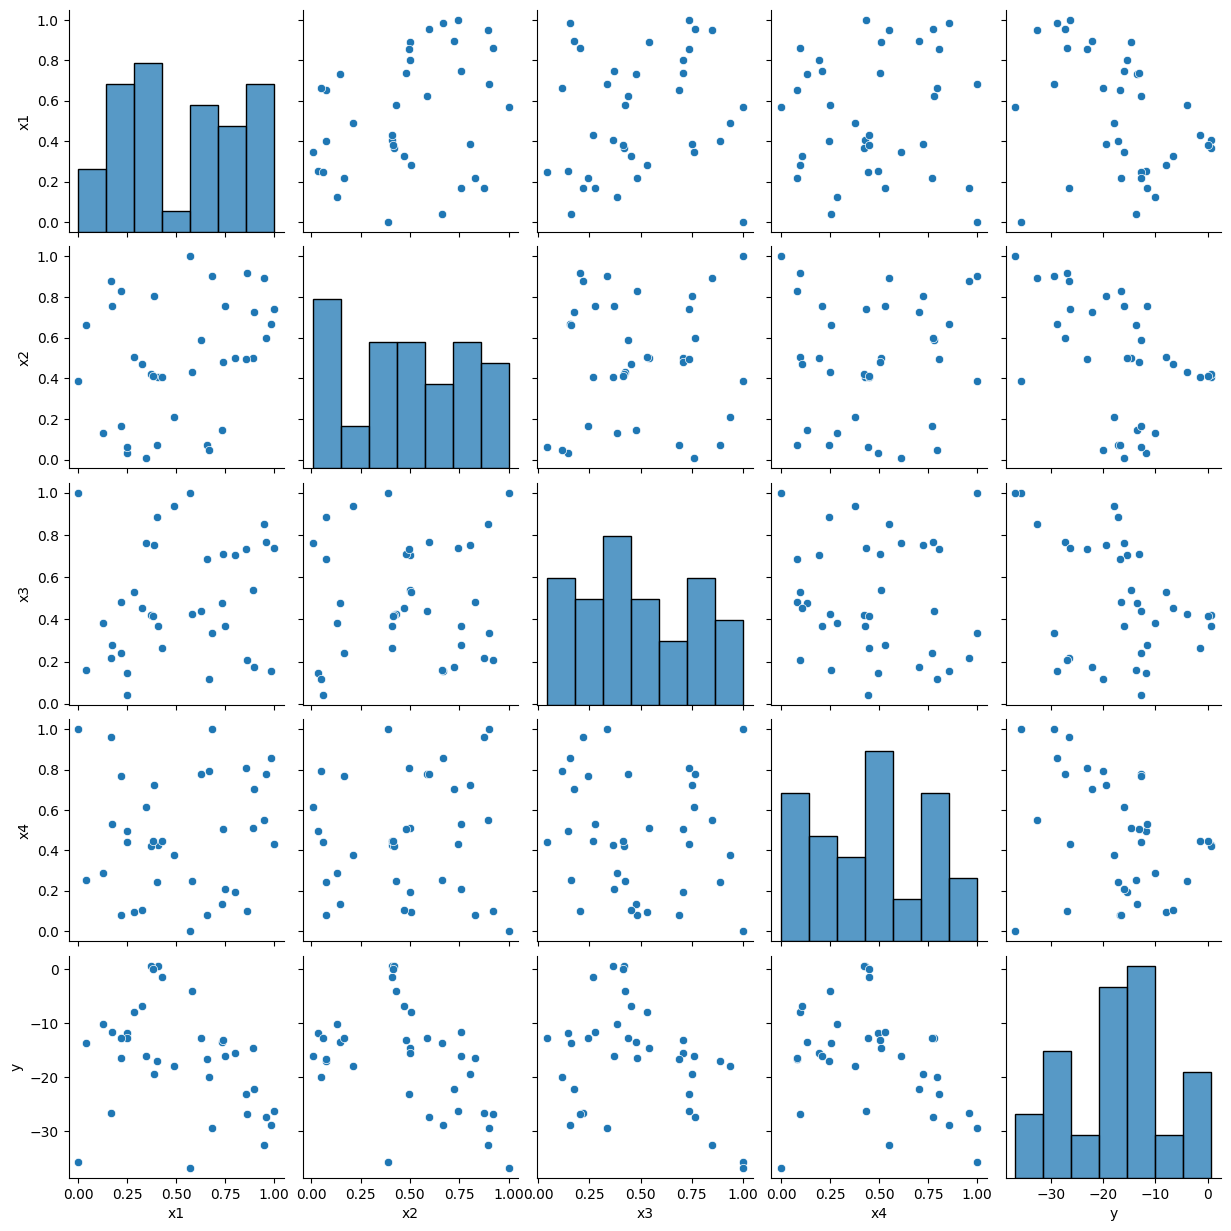

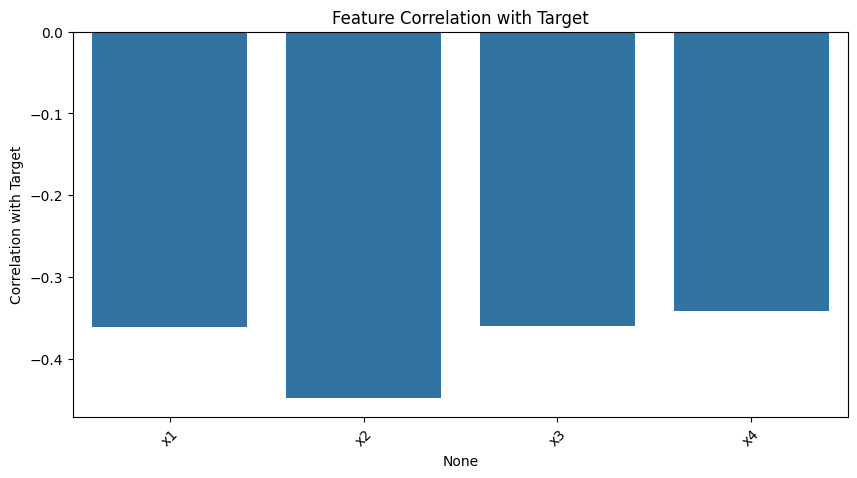

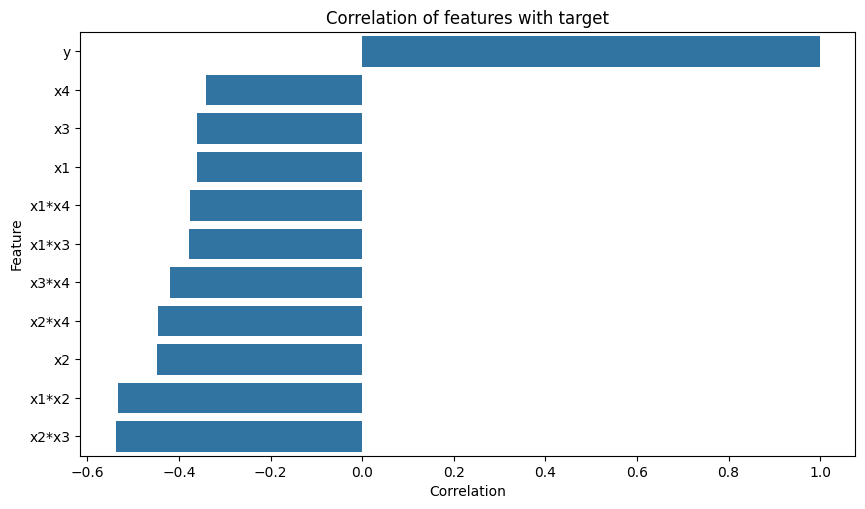

------------ function_4 --------------
       x2     x3       y
0   0.726  0.175 -22.108
1   0.500  0.539 -14.601
2   0.034  0.145 -11.700
3   0.006  0.761 -16.054
4   0.130  0.384 -10.070
5   0.500  0.707 -15.487
6   0.060  0.042 -12.682
7   0.757  0.369 -16.026
8   0.073  0.887 -17.049
9   0.587  0.439 -12.742
10  0.598  0.766 -27.316
11  0.145  0.477 -13.528
12  0.072  0.687 -16.679
13  0.832  0.483 -16.507
14  0.212  0.939 -17.818
15  0.877  0.217 -26.562
16  0.166  0.241 -12.758
17  0.805  0.752 -19.442
18  0.667  0.157 -28.903
19  0.665  0.162 -13.703
20  0.903  0.335 -29.427
21  0.757  0.277 -11.566
22  0.920  0.206 -26.858
23  0.506  0.531  -7.967
24  0.472  0.453  -6.702
25  0.895  0.852 -32.626
26  0.047  0.117 -19.989
27  0.429  0.426  -4.026
28  0.482  0.709 -13.123
29  0.494  0.735 -23.139
30  0.742  0.737 -26.332
31  0.408  0.367   0.609
32  0.388  1.000 -35.652
33  0.408  0.265  -1.371
34  1.000  1.000 -36.764
35  0.421  0.421   0.702
36  0.414  0.414   0.125

Max of 0.7

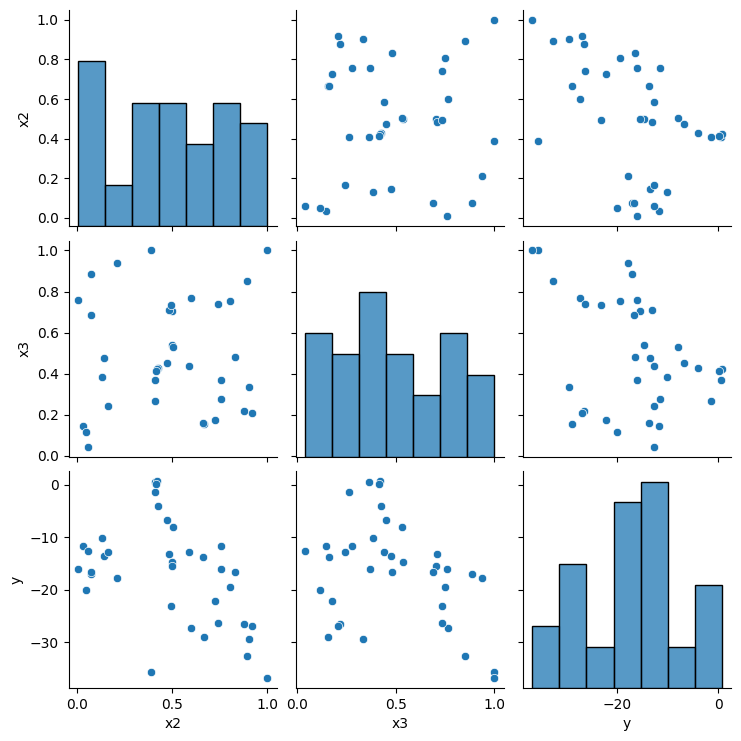

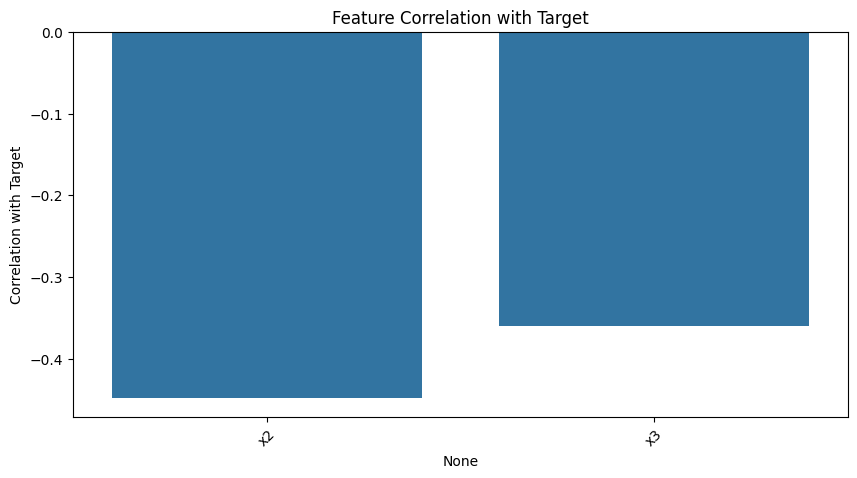

GP kernel=
3.16**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=0.01)
Next acquisition point (UCB): [0.36842105 0.36842105]
queryPoint=[0.36842105 0.36842105]
queryPoint (formatted)=0.368421-0.368421


GP kernel=
3.16**2 * Matern(length_scale=[1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=0.01)
Next acquisition point (UCB): [0.37931034 0.4137931  0.4137931  0.4137931 ]
queryPoint=[0.37931034 0.4137931  0.4137931  0.4137931 ]
queryPoint (formatted)=0.379310-0.413793-0.413793-0.413793


array([0.37931034, 0.4137931 , 0.4137931 , 0.4137931 ])

In [10]:
f4 = BBfcn(4)
print(f4)
f4.plot_feature_correlations()
f4.plot_correlations_with_cross_terms()

# dimension reduction for f4()
class f4dimRedTransform(Transformation):
    def __init__(self):
        pass
    def apply(self,data):
        data.drop(columns=["x1","x4"],inplace=True)

tr = f4dimRedTransform()
f4_dimRed = BBfcn(4)
f4_dimRed.transform(tr)
print(f4_dimRed)
f4_dimRed.plot_feature_correlations()
# f4_dimRed.plot_correlations_with_cross_terms()
kernel = C(10, (0.001, 20)) * Matern(length_scale=[1,1],nu=2.5) + WhiteKernel(noise_level=0.01)
f4_dimRed.nextPointBayesianOptim(kernel,numgrid=20,acqFcn="UCB",beta=0.5)

# Full dimensional GP for f4()
kernel = C(10, (0.001, 20)) * Matern(length_scale=[1,1,1,1],nu=2.5) + WhiteKernel(noise_level=0.01)
f4.nextPointBayesianOptim(kernel,numgrid=30,acqFcn="UCB",beta=0)


# Function 05

- beta is still 2
- This is still pushing out to the edge of the space along an obvious upwards ramp
- This path should be exhausted next week in the x1,x3 direction.  Anything to do in the other coordinates?
standard Bayesian with beta = 0 and finer grid gave something new
- would benefit from gradient search and local model because secondary variables x1 and x4 are still significant

------------ function_5 --------------
       x1     x2     x3     x4         y
0   0.191  0.038  0.607  0.415    64.443
1   0.759  0.537  0.656  0.360    18.301
2   0.438  0.804  0.210  0.151     0.113
3   0.706  0.534  0.264  0.482     4.211
4   0.836  0.194  0.664  0.786   258.371
5   0.683  0.119  0.829  0.568    78.434
6   0.554  0.667  0.324  0.815    57.572
7   0.352  0.322  0.117  0.473   109.572
8   0.154  0.729  0.423  0.443     8.848
9   0.463  0.630  0.108  0.958   233.224
10  0.677  0.359  0.480  0.073    24.423
11  0.584  0.147  0.348  0.429    64.420
12  0.307  0.317  0.623  0.095    63.477
13  0.511  0.818  0.729  0.112    79.729
14  0.439  0.774  0.378  0.934   355.807
15  0.224  0.846  0.879  0.879  1088.860
16  0.725  0.480  0.089  0.760    28.867
17  0.355  0.640  0.418  0.123    45.182
18  0.120  0.863  0.643  0.850   431.613
19  0.127  0.153  0.770  0.191     9.972
20  0.255  0.962  1.000  0.999  3964.329
21  1.000  0.000  1.000  1.000  4440.523
22  1.000  1.000  

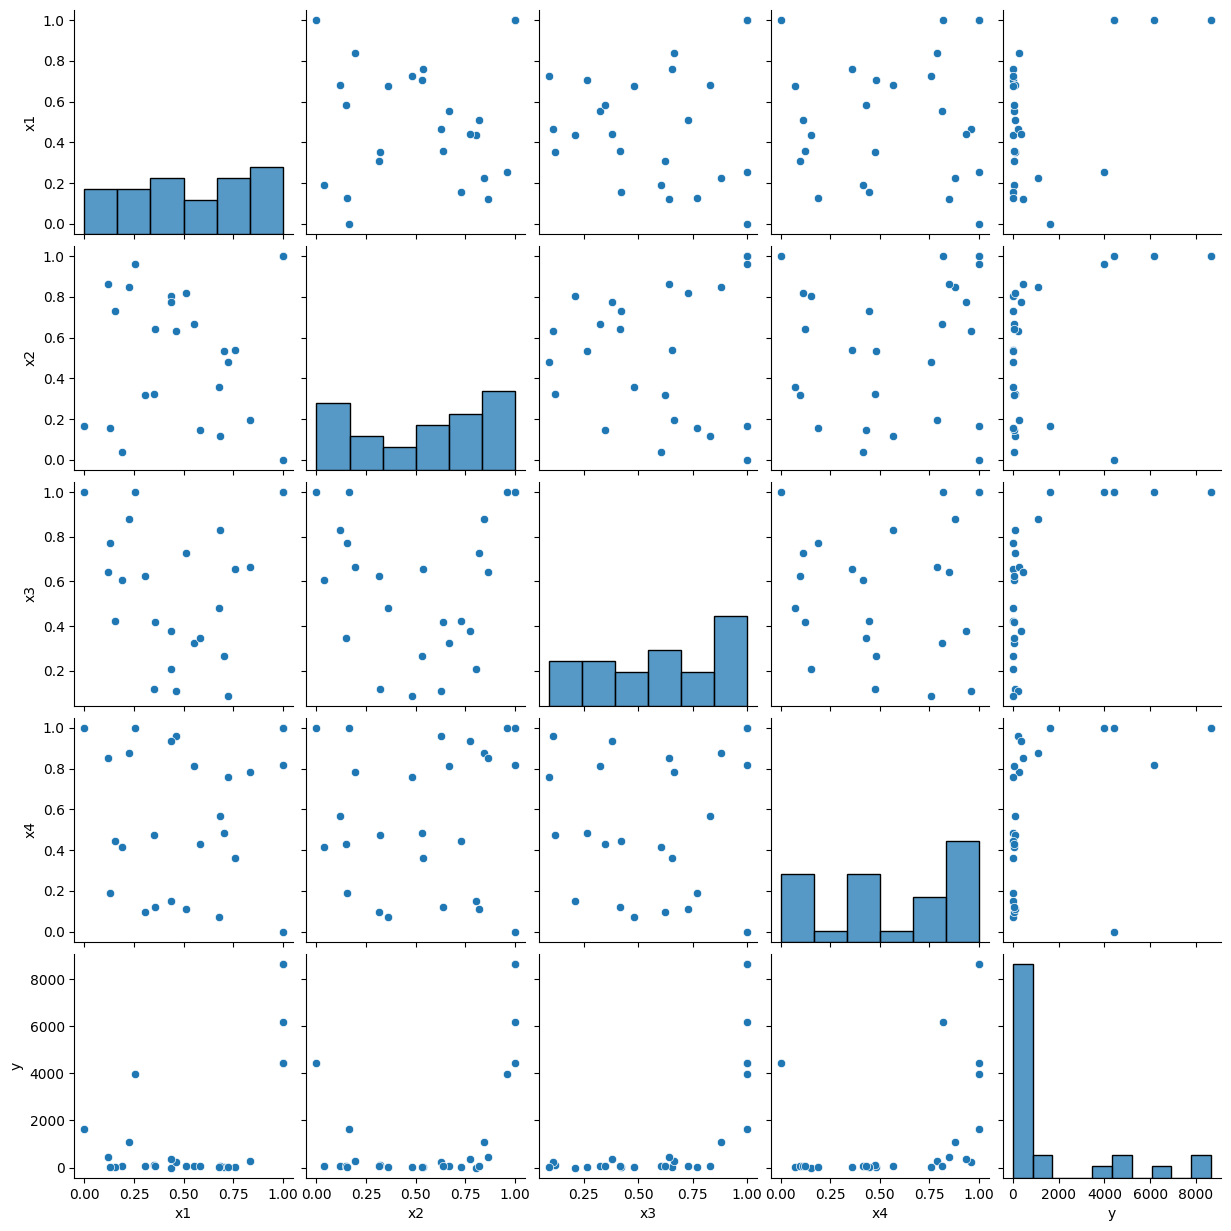

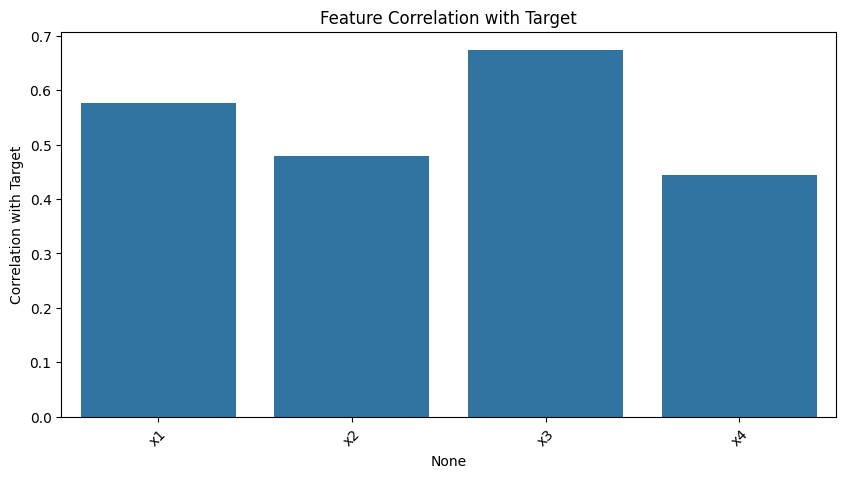

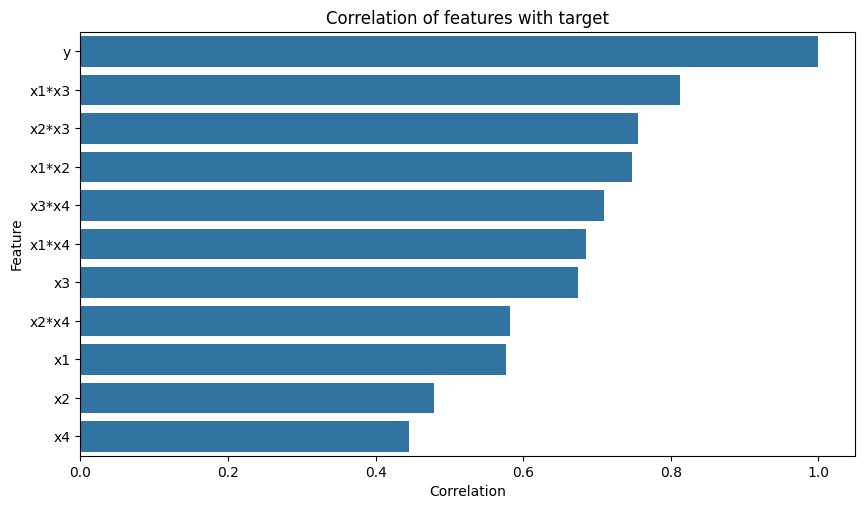

------------ function_5 --------------
       x1     x3         y
0   0.191  0.607    64.443
1   0.759  0.656    18.301
2   0.438  0.210     0.113
3   0.706  0.264     4.211
4   0.836  0.664   258.371
5   0.683  0.829    78.434
6   0.554  0.324    57.572
7   0.352  0.117   109.572
8   0.154  0.423     8.848
9   0.463  0.108   233.224
10  0.677  0.480    24.423
11  0.584  0.348    64.420
12  0.307  0.623    63.477
13  0.511  0.729    79.729
14  0.439  0.378   355.807
15  0.224  0.879  1088.860
16  0.725  0.089    28.867
17  0.355  0.418    45.182
18  0.120  0.643   431.613
19  0.127  0.770     9.972
20  0.255  1.000  3964.329
21  1.000  1.000  4440.523
22  1.000  1.000  6169.418
23  0.000  1.000  1618.709
24  1.000  1.000  4440.523
25  1.000  1.000  8662.483
26  1.000  1.000  8662.483

Max of 8662.4825 realized at row
     x1   x3         y
25  1.0  1.0  8662.483



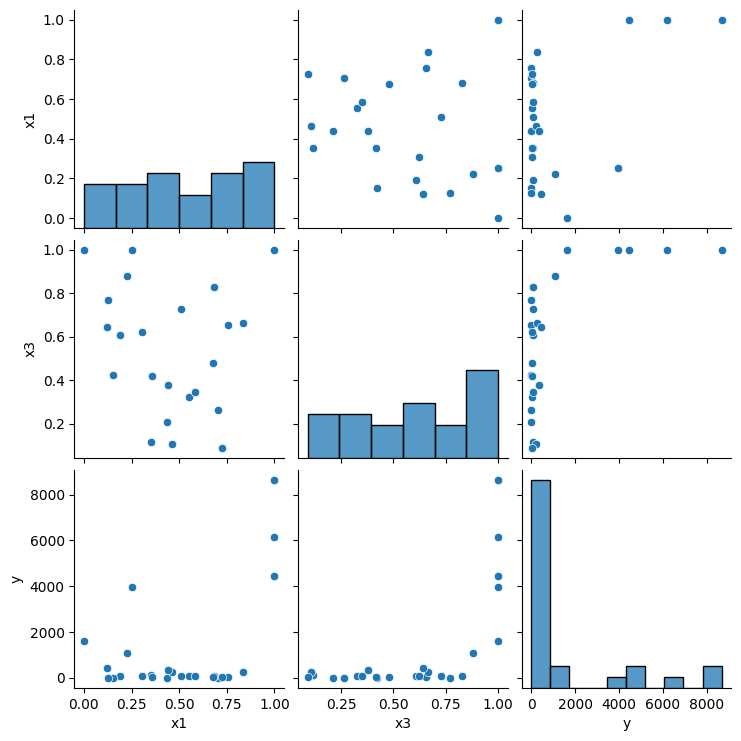

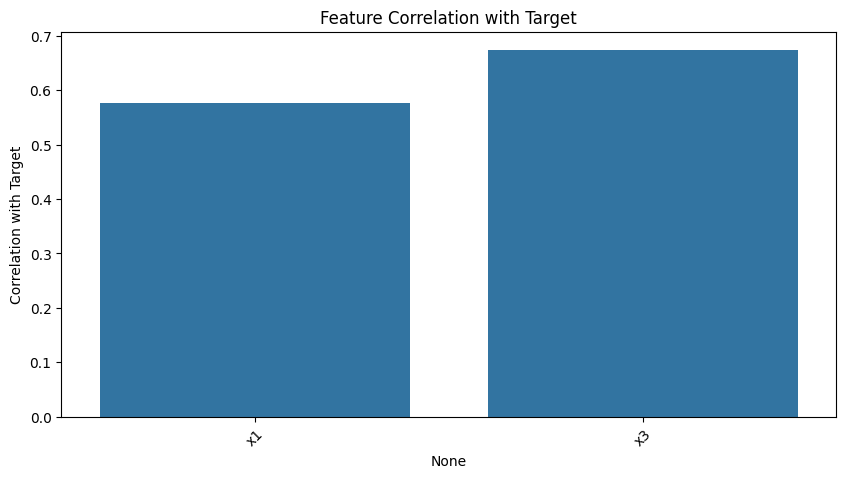

GP kernel=
3.16**2 * Matern(length_scale=[0.01, 0.01], nu=2.5) + WhiteKernel(noise_level=10)
Next acquisition point (UCB): [1. 1.]
queryPoint=[1. 1.]
queryPoint (formatted)=1.000000-1.000000


GP kernel=
3.16**2 * Matern(length_scale=[0.01, 0.01, 0.01, 0.01], nu=2.5) + WhiteKernel(noise_level=10)
Next acquisition point (UCB): [1. 1. 1. 1.]
queryPoint=[1. 1. 1. 1.]
queryPoint (formatted)=1.000000-1.000000-1.000000-1.000000


array([1., 1., 1., 1.])

In [11]:
f5 = BBfcn(5)
print(f5)
f5.plot_feature_correlations()
f5.plot_correlations_with_cross_terms()

# dimension reduction for f5()
class f5dimRedTransform(Transformation):
    def __init__(self):
        pass
    def apply(self,data):
        data.drop(columns=["x2","x4"],inplace=True)

tr = f5dimRedTransform()
f5_dimRed = BBfcn(5)
f5_dimRed.transform(tr)
print(f5_dimRed)
f5_dimRed.plot_feature_correlations()
# f4_dimRed.plot_correlations_with_cross_terms()
kernel = C(10, (0.001, 10000)) * Matern(length_scale=[0.01,0.01],nu=2.5) + WhiteKernel(noise_level=10.0)
f5_dimRed.nextPointBayesianOptim(kernel,numgrid=20,acqFcn="UCB",beta=2)

# Full dimensional GP for f5()
kernel = C(10, (0.001, 10000)) * Matern(length_scale=[0.01,0.01,0.01,0.01],nu=2.5) + WhiteKernel(noise_level=10.0)
f5.nextPointBayesianOptim(kernel,numgrid=20,acqFcn="UCB",beta=2)


# Function 06

- beta is zero
- dominated by x4, x5, but the other dimenions are significant.  Would benefit from a local search and gradient

------------ function_6 --------------
       x1     x2     x3     x4     x5      y
0   0.728  0.155  0.733  0.694  0.056 -0.714
1   0.242  0.844  0.578  0.679  0.502 -1.210
2   0.730  0.748  0.680  0.357  0.671 -1.672
3   0.771  0.114  0.047  0.648  0.274 -1.536
4   0.619  0.332  0.187  0.756  0.329 -0.829
5   0.785  0.911  0.708  0.959  0.005 -1.247
6   0.145  0.897  0.896  0.726  0.236 -1.234
7   0.945  0.288  0.979  0.962  0.598 -1.694
8   0.126  0.863  0.029  0.247  0.751 -2.571
9   0.758  0.356  0.017  0.434  0.112 -1.309
10  0.537  0.309  0.412  0.388  0.523 -1.145
11  0.958  0.236  0.099  0.157  0.071 -1.913
12  0.629  0.803  0.811  0.046  0.111 -1.623
13  0.022  0.428  0.836  0.489  0.511 -1.357
14  0.439  0.699  0.427  0.109  0.878 -2.018
15  0.259  0.794  0.642  0.197  0.593 -1.703
16  0.432  0.716  0.342  0.705  0.615 -1.294
17  0.783  0.536  0.443  0.860  0.010 -0.936
18  0.922  0.932  0.415  0.595  0.736 -2.156
19  0.127  0.291  0.065  0.681  0.893 -1.747
20  0.994  0.211

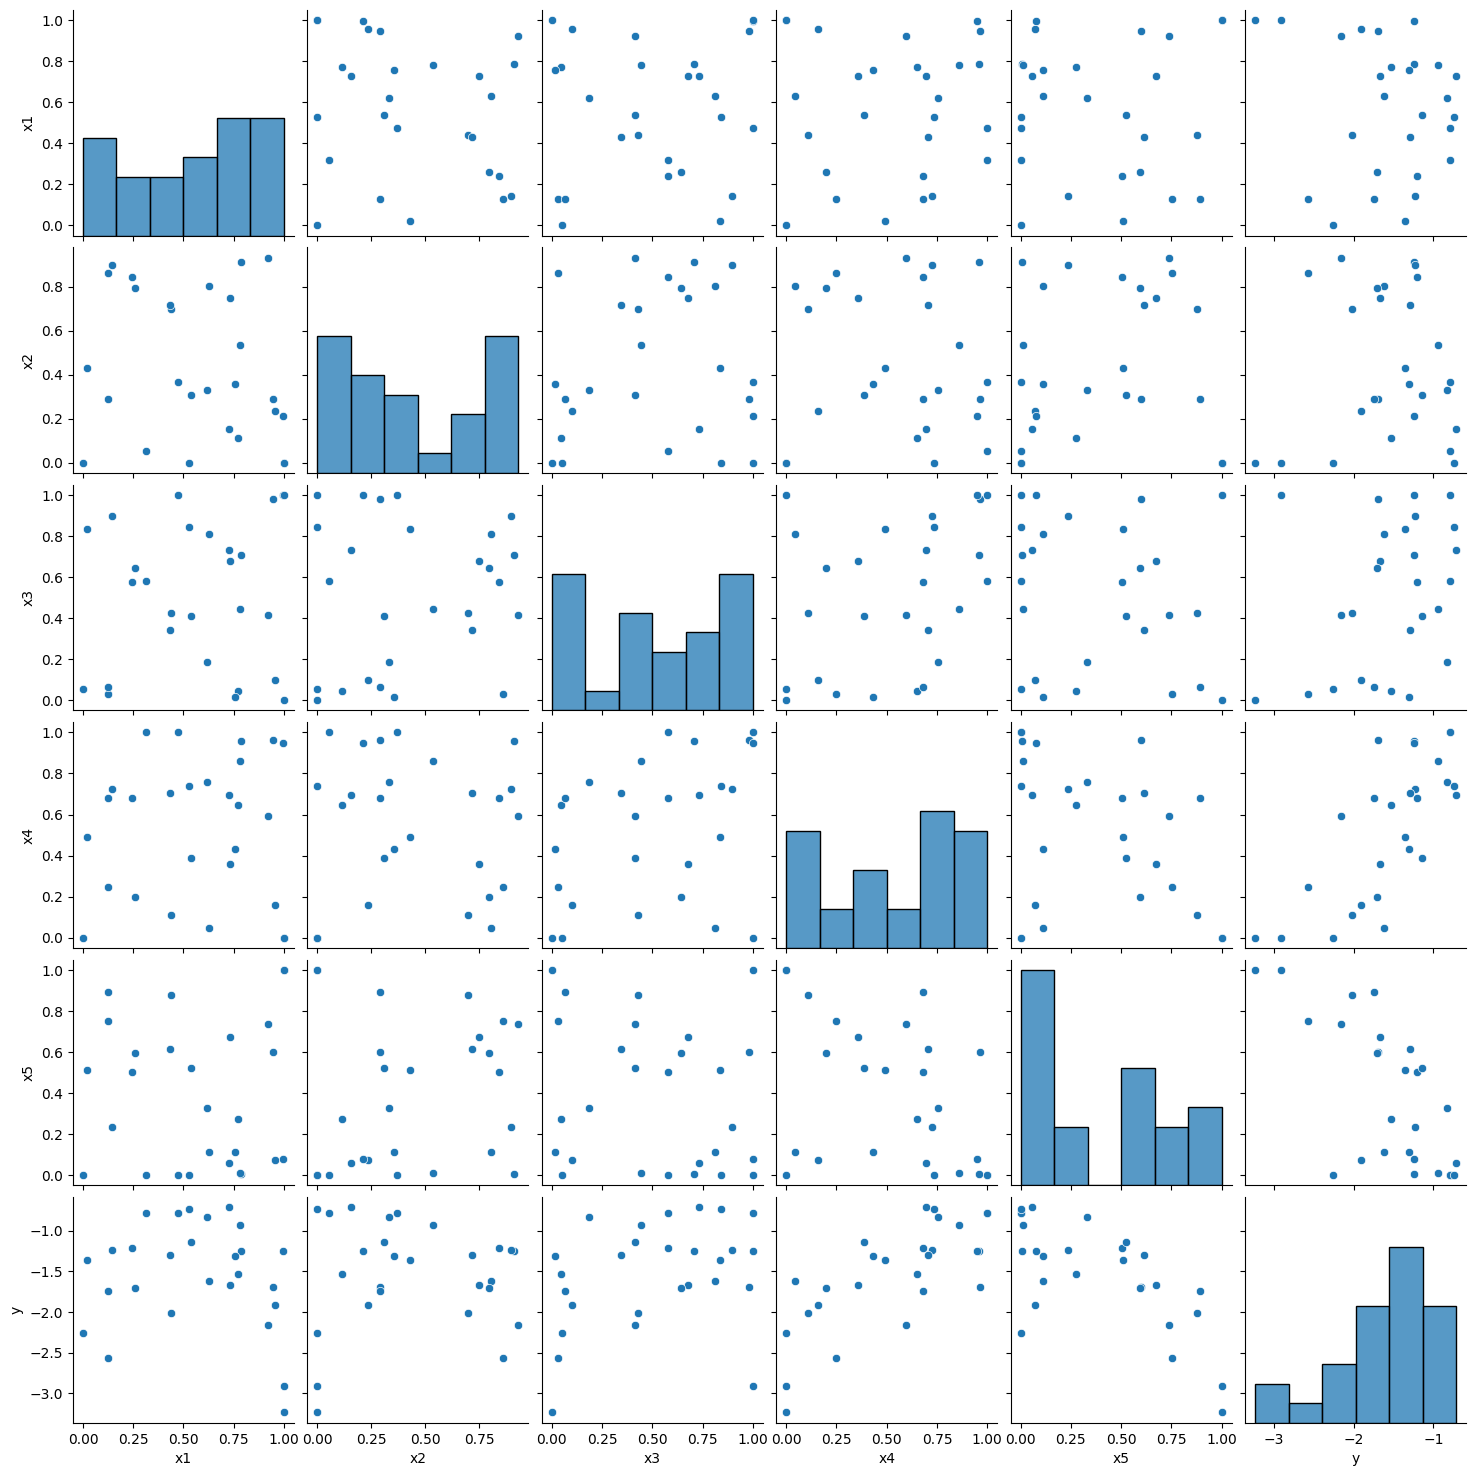

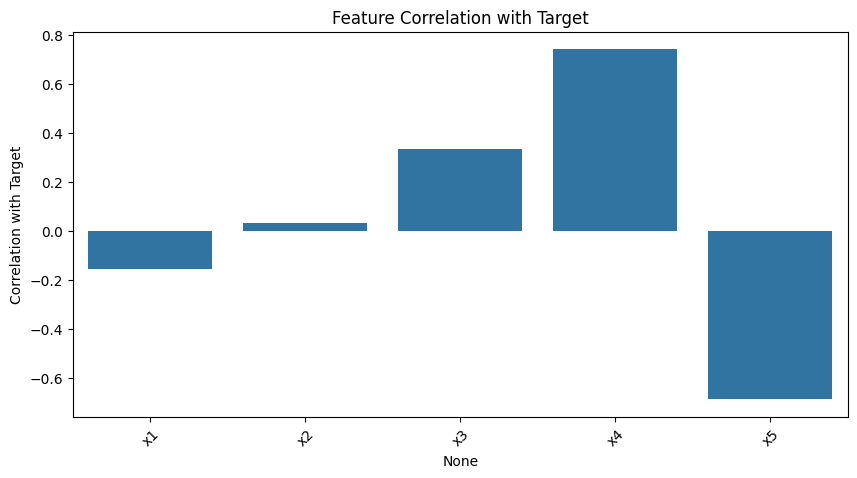

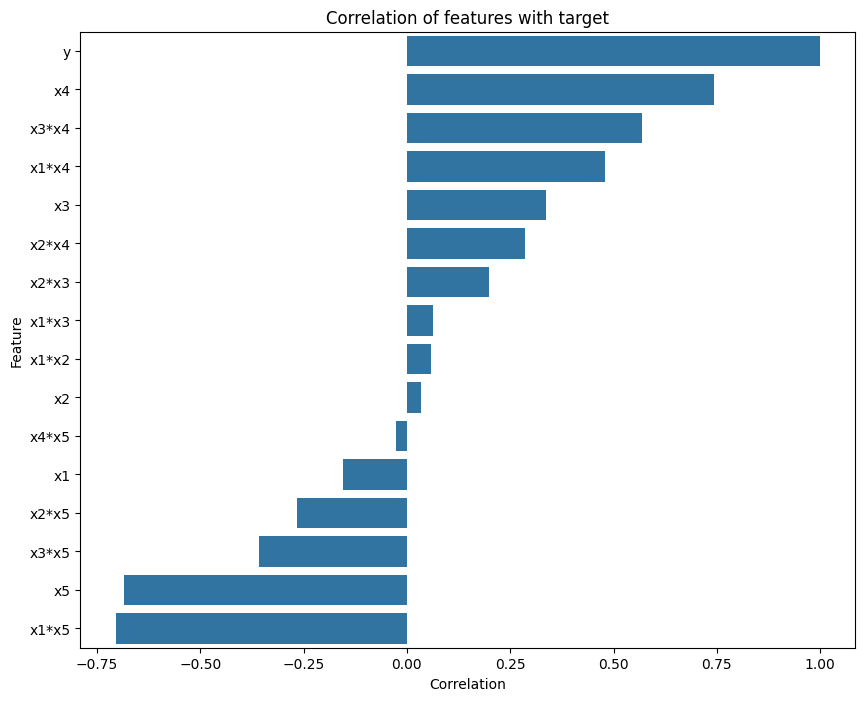

------------ function_6 --------------
       x4     x5      y
0   0.694  0.056 -0.714
1   0.679  0.502 -1.210
2   0.357  0.671 -1.672
3   0.648  0.274 -1.536
4   0.756  0.329 -0.829
5   0.959  0.005 -1.247
6   0.726  0.236 -1.234
7   0.962  0.598 -1.694
8   0.247  0.751 -2.571
9   0.434  0.112 -1.309
10  0.388  0.523 -1.145
11  0.157  0.071 -1.913
12  0.046  0.111 -1.623
13  0.489  0.511 -1.357
14  0.109  0.878 -2.018
15  0.197  0.593 -1.703
16  0.705  0.615 -1.294
17  0.860  0.010 -0.936
18  0.595  0.736 -2.156
19  0.681  0.893 -1.747
20  0.947  0.077 -1.245
21  1.000  0.000 -0.785
22  0.000  1.000 -2.910
23  0.000  0.000 -2.256
24  0.000  1.000 -3.235
25  1.000  0.000 -0.788
26  0.737  0.000 -0.739

Max of -0.7142649478202404 realized at row
      x4     x5      y
0  0.694  0.056 -0.714



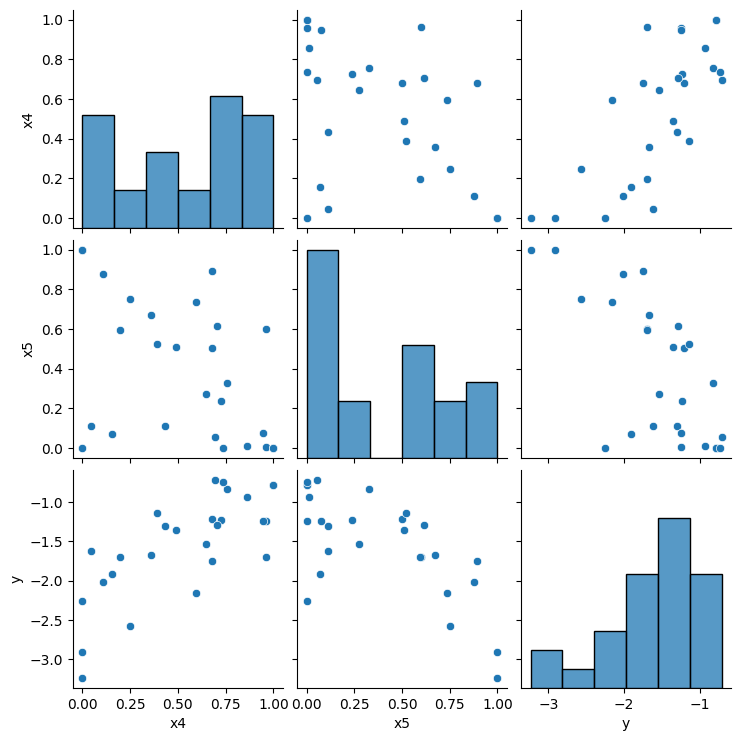

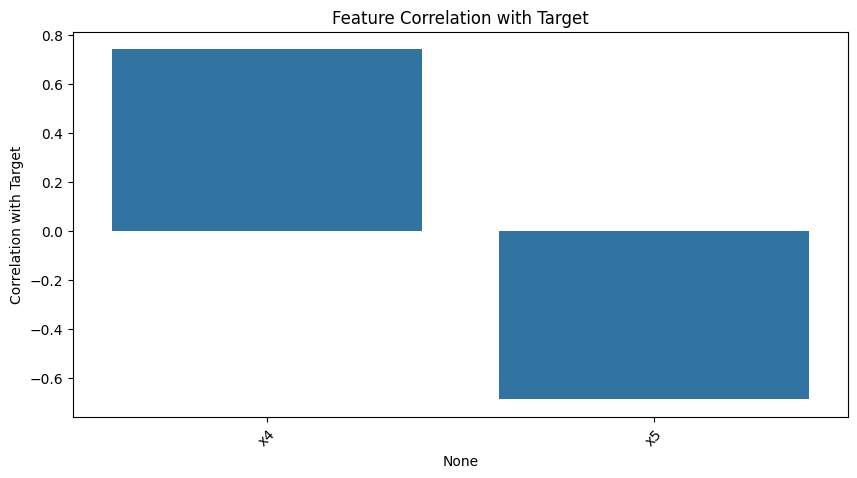

GP kernel=
3.16**2 * Matern(length_scale=[0.2, 0.2], nu=2.5) + WhiteKernel(noise_level=1)
Next acquisition point (UCB): [0.84210526 0.        ]
queryPoint=[0.84210526 0.        ]
queryPoint (formatted)=0.842105-0.000000


GP kernel=
3.16**2 * Matern(length_scale=[0.2, 0.2, 0.2, 0.2, 0.2], nu=2.5) + WhiteKernel(noise_level=1)
Next acquisition point (UCB): [0.52631579 0.26315789 0.57894737 0.89473684 0.        ]
queryPoint=[0.52631579 0.26315789 0.57894737 0.89473684 0.        ]
queryPoint (formatted)=0.526316-0.263158-0.578947-0.894737-0.000000


array([0.52631579, 0.26315789, 0.57894737, 0.89473684, 0.        ])

In [12]:
f6 = BBfcn(6)
print(f6)
f6.plot_feature_correlations()
f6.plot_correlations_with_cross_terms()

# dimension reduction for f6()
class f6dimRedTransform(Transformation):
    def __init__(self):
        pass
    def apply(self,data):
        data.drop(columns=["x1","x2","x3"],inplace=True)

f6_dimRed = BBfcn(6)
f6_dimRed.transform(f6dimRedTransform())
print(f6_dimRed)
f6_dimRed.plot_feature_correlations()
kernel = C(10, (0.001, 10)) * Matern(length_scale=[0.2,0.2],nu=2.5) + WhiteKernel(noise_level=1.0)
f6_dimRed.nextPointBayesianOptim(kernel,numgrid=20,acqFcn="UCB",beta=0.5)

#full dimensional GP for f6()
kernel = C(10, (0.001, 10)) * Matern(length_scale=[0.2,0.2,0.2,0.2,0.2],nu=2.5) + WhiteKernel(noise_level=1.0)
f6.nextPointBayesianOptim(kernel,numgrid=20,acqFcn="UCB",beta=0)



# Function 07

- set beta to 0.0
- One of the more interesting functions because lots of local peaks
- Would benefit from trust regions approacht

------------ function_7 --------------
       x1     x2     x3     x4     x5     x6          y
0   0.273  0.324  0.897  0.833  0.154  0.796  6.044e-01
1   0.543  0.925  0.342  0.646  0.718  0.343  5.628e-01
2   0.091  0.662  0.066  0.259  0.963  0.640  7.503e-03
3   0.119  0.615  0.906  0.855  0.414  0.585  6.142e-02
4   0.630  0.838  0.680  0.732  0.527  0.348  2.730e-01
5   0.765  0.256  0.609  0.218  0.323  0.096  8.375e-02
6   0.058  0.492  0.247  0.218  0.420  0.731  1.365e+00
7   0.195  0.079  0.555  0.171  0.015  0.107  9.264e-02
8   0.642  0.837  0.022  0.101  0.683  0.692  1.787e-02
9   0.790  0.196  0.576  0.074  0.259  0.051  3.356e-02
10  0.528  0.457  0.360  0.362  0.817  0.637  7.352e-02
11  0.723  0.012  0.064  0.165  0.079  0.360  2.063e-01
12  0.076  0.335  0.133  0.608  0.918  0.822  8.826e-03
13  0.942  0.377  0.486  0.229  0.083  0.712  2.684e-01
14  0.149  0.034  0.729  0.316  0.022  0.517  6.115e-01
15  0.817  0.548  0.103  0.124  0.728  0.450  1.480e-02
16  0.418

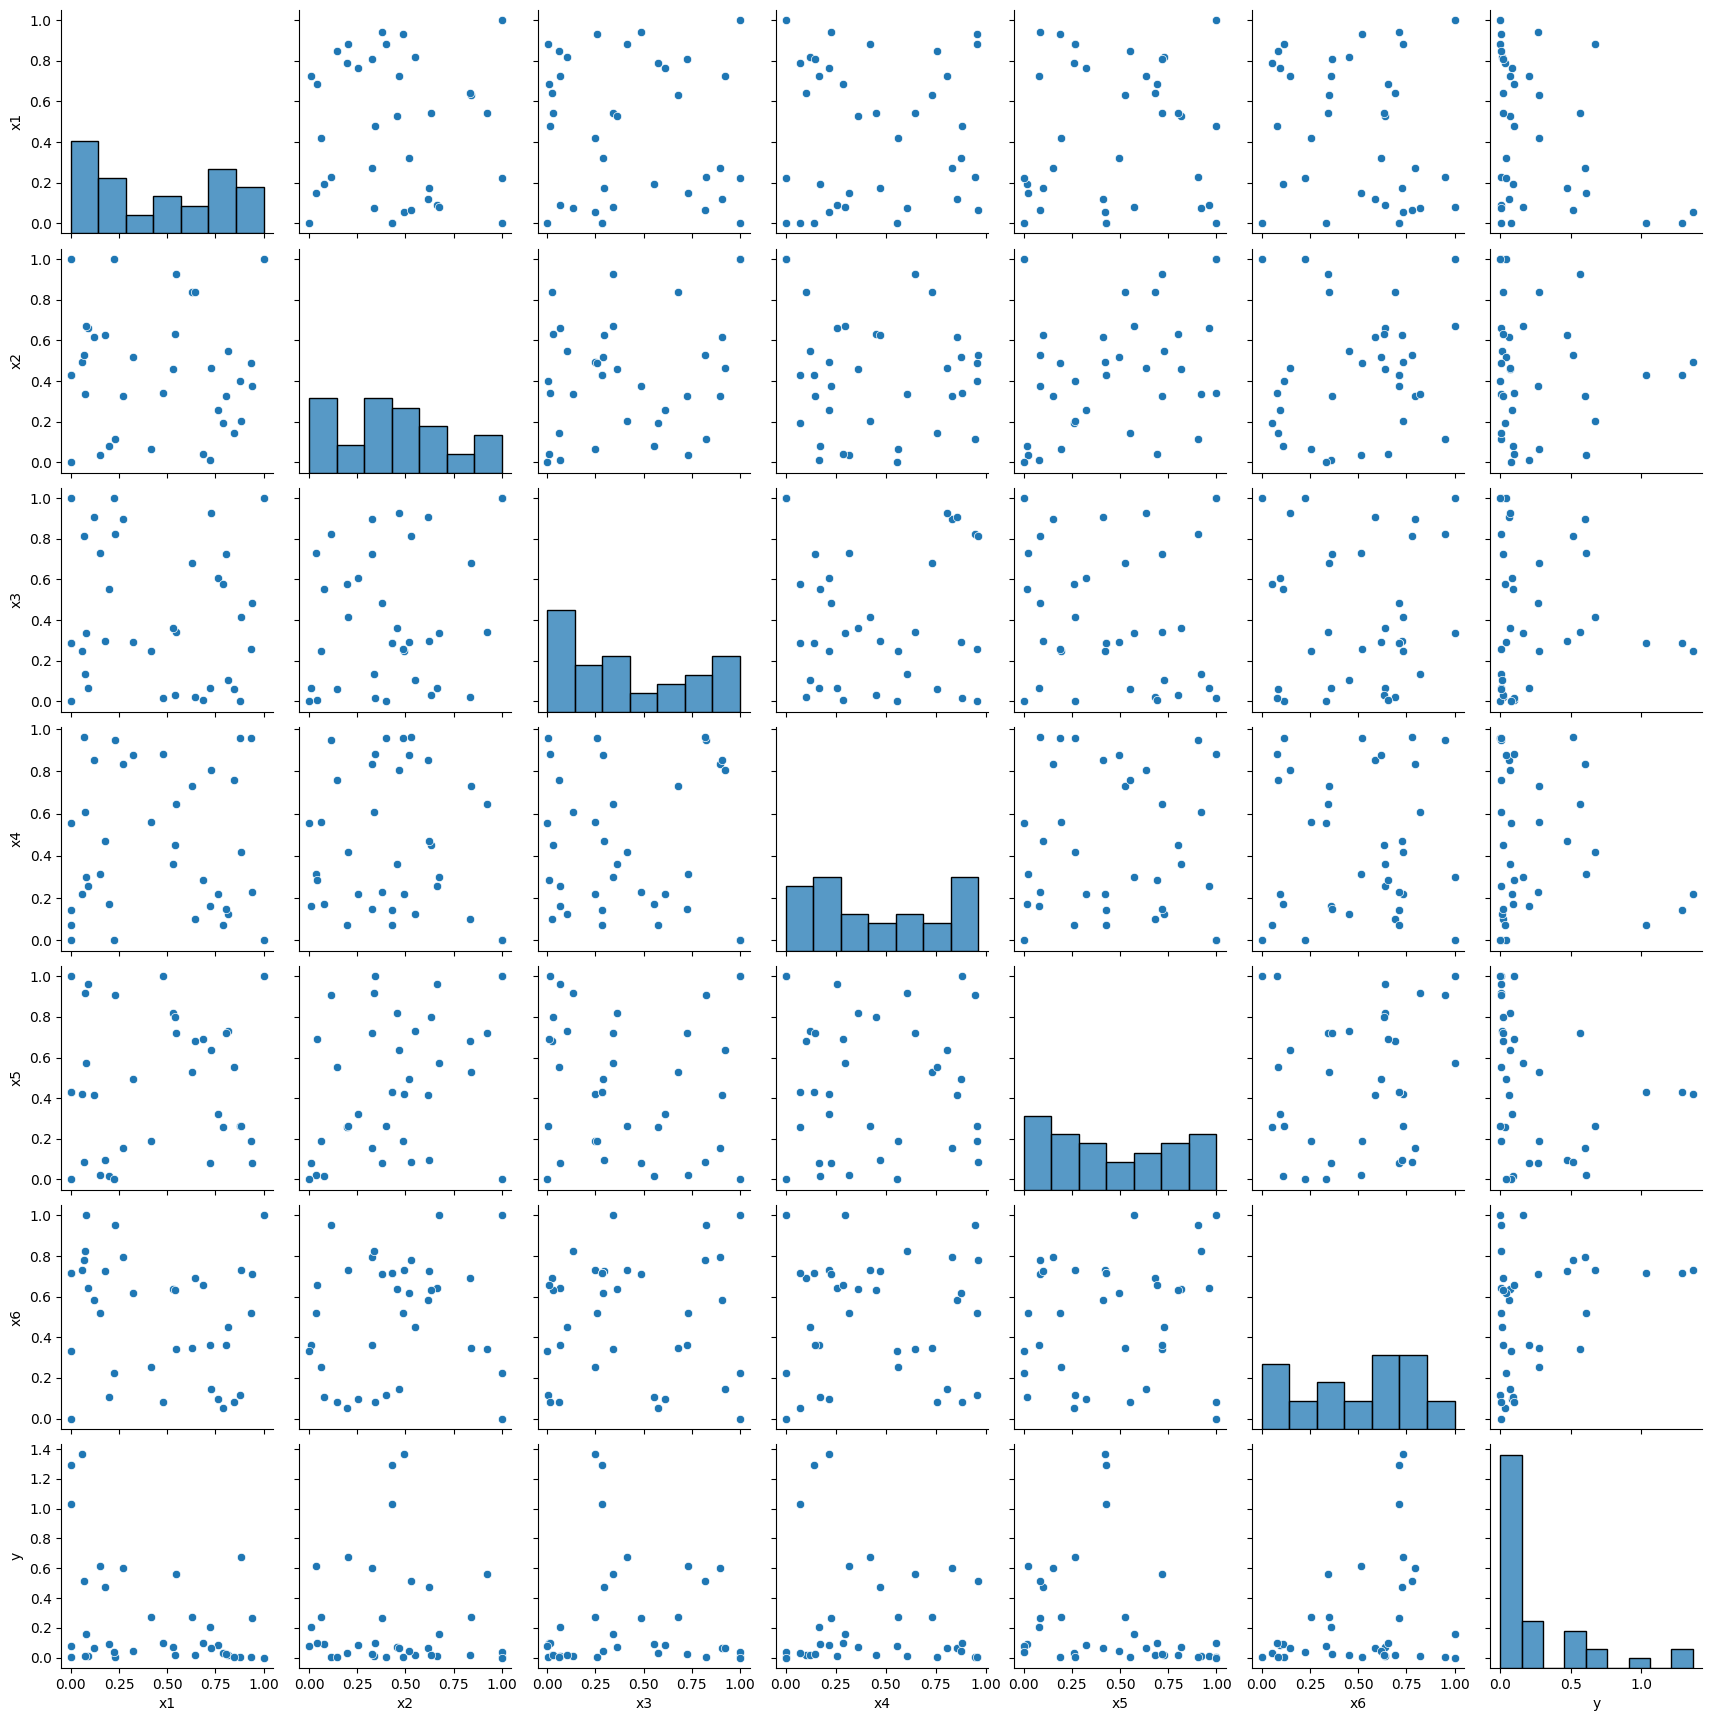

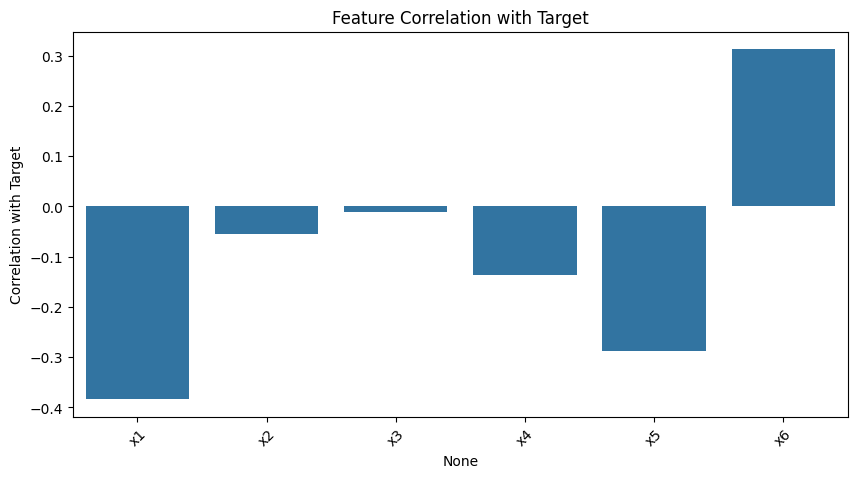

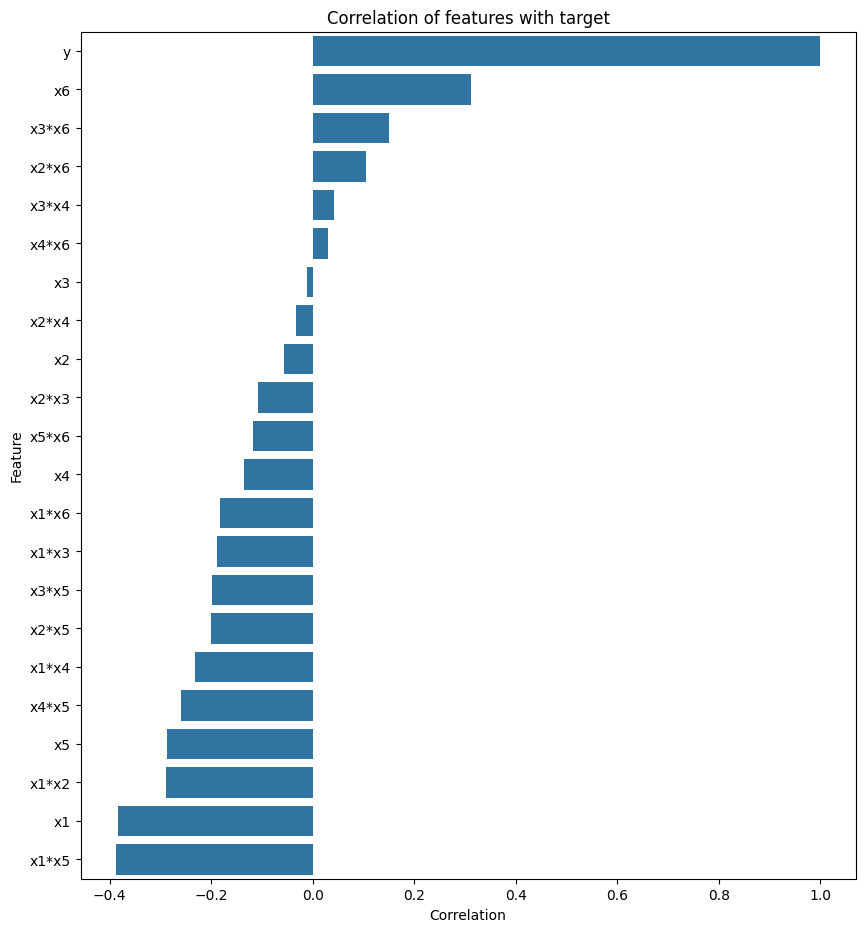

------------ function_7 --------------
       x5     x6          y
0   0.154  0.796  6.044e-01
1   0.718  0.343  5.628e-01
2   0.963  0.640  7.503e-03
3   0.414  0.585  6.142e-02
4   0.527  0.348  2.730e-01
5   0.323  0.096  8.375e-02
6   0.420  0.731  1.365e+00
7   0.015  0.107  9.264e-02
8   0.683  0.692  1.787e-02
9   0.259  0.051  3.356e-02
10  0.817  0.637  7.352e-02
11  0.079  0.360  2.063e-01
12  0.918  0.822  8.826e-03
13  0.083  0.712  2.684e-01
14  0.022  0.517  6.115e-01
15  0.728  0.450  1.480e-02
16  0.192  0.255  2.749e-01
17  0.635  0.143  6.676e-02
18  0.495  0.619  4.212e-02
19  0.265  0.115  2.701e-03
20  0.799  0.634  1.821e-02
21  0.905  0.951  7.016e-03
22  0.692  0.656  1.005e-01
23  0.098  0.728  4.754e-01
24  0.265  0.731  6.751e-01
25  0.087  0.778  5.165e-01
26  0.190  0.520  3.777e-03
27  0.552  0.081  3.134e-03
28  0.719  0.363  2.134e-02
29  0.999  0.080  9.541e-02
30  0.575  1.000  1.604e-01
31  0.000  0.333  8.051e-02
32  1.000  0.000  6.143e-03
33  0.000

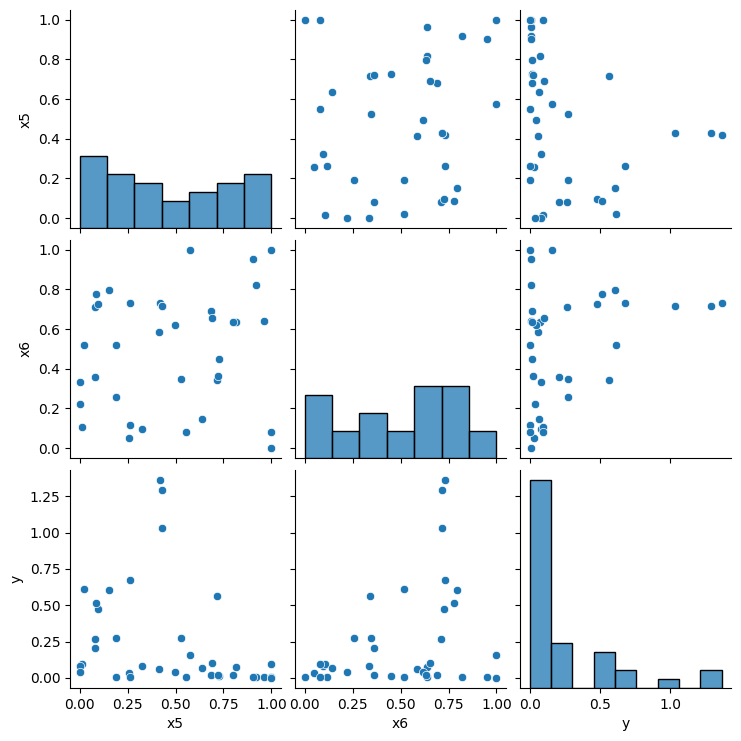

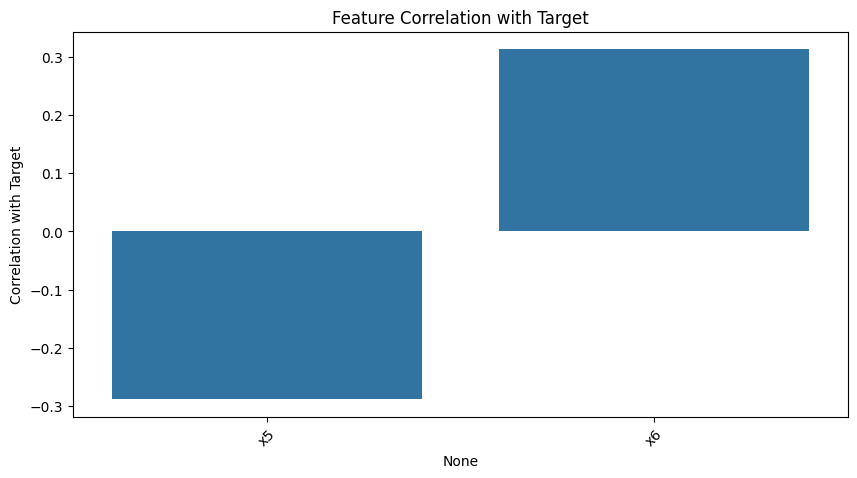

GP kernel=
3.16**2 * Matern(length_scale=[0.2, 0.2], nu=2.5) + WhiteKernel(noise_level=0.0001)
Next acquisition point (UCB): [0.42105263 0.73684211]
queryPoint=[0.42105263 0.73684211]
queryPoint (formatted)=0.421053-0.736842


/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning:

The optimal value found for dimension 2 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.



GP kernel=
3.16**2 * Matern(length_scale=[0.2, 0.2, 0.2, 0.2, 0.2, 0.2], nu=2.5) + WhiteKernel(noise_level=0.0001)
Next acquisition point (UCB): [0.         0.42857143 0.28571429 0.21428571 0.42857143 0.71428571]
queryPoint=[0.         0.42857143 0.28571429 0.21428571 0.42857143 0.71428571]
queryPoint (formatted)=0.000000-0.428571-0.285714-0.214286-0.428571-0.714286


array([0.        , 0.42857143, 0.28571429, 0.21428571, 0.42857143,
       0.71428571])

In [13]:
f7 = BBfcn(7)
print(f7)
f7.plot_feature_correlations()
f7.plot_correlations_with_cross_terms()

f7_dimRed = BBfcn(7)
# dimension reduction for f7()
class f7dimRedTransform(Transformation):
    def __init__(self):
        pass
    def apply(self,data):
        data.drop(columns=["x1","x2","x3","x4"],inplace=True)
f7_dimRed.transform(f7dimRedTransform())
print(f7_dimRed)
f7_dimRed.plot_feature_correlations()
kernel = C(10, (0.00001, 1)) * Matern(length_scale=[0.2,0.2],nu=2.5) + WhiteKernel(noise_level=1e-4)
f7_dimRed.nextPointBayesianOptim(kernel,numgrid=20,acqFcn="UCB",beta=0.5)

#full dimensional GP for f7()
kernel = C(10, (0.00001, 1)) * Matern(length_scale=[0.2,0.2,0.2,0.2,0.2,0.2],nu=2.5) + WhiteKernel(noise_level=1e-4)
f7.nextPointBayesianOptim(kernel,numgrid=15,acqFcn="UCB",beta=0)

# Function 08

- Completely blocked due to gridding issue
- Desperately needs optimization-driven approach
- For this week performed a manual hack: Use the fine-grained query from the dominant axis x1 and x3 and overlay it on top of the course-grained query for the other 6 dimensions

ie the 2D BO point was (for dimensions x1 and x3)

   Next acquisition point (UCB): [0.15789474 0.15789474]
   queryPoint=[0.15789474 0.15789474]
   queryPoint (formatted)=0.157895-0.157895

and the global point on the coarse grid was (repeated

   0.142857-0.142857-0.142857-0.142857-0.857143-0.428571-0.285714-1.00000

and I overlaid the x1 and x3 coordinates from teh reduced dimension query on the overall query to give

   0.157895-0.142857-0.157895-0.142857-0.857143-0.428571-0.285714-1.00000

Obviously this is not sustainable.  This function would benefit from an optimization-driven approach, as opposed to gridding and a multi-head approach


------------ function_8 --------------
       x1     x2     x3     x4     x5     x6     x7     x8      y
0   0.605  0.292  0.908  0.356  0.202  0.575  0.310  0.734  7.399
1   0.178  0.566  0.995  0.210  0.320  0.708  0.635  0.107  7.005
2   0.009  0.812  0.521  0.076  0.265  0.092  0.592  0.367  8.459
3   0.506  0.654  0.363  0.178  0.094  0.197  0.756  0.292  8.284
4   0.360  0.249  0.496  0.709  0.115  0.289  0.557  0.594  8.606
5   0.779  0.003  0.338  0.520  0.821  0.537  0.551  0.660  8.542
6   0.909  0.062  0.238  0.767  0.132  0.990  0.688  0.742  7.327
7   0.586  0.881  0.745  0.546  0.010  0.749  0.231  0.098  7.300
8   0.761  0.855  0.382  0.337  0.690  0.310  0.631  0.042  7.958
9   0.985  0.700  0.999  0.180  0.580  0.231  0.491  0.314  5.592
10  0.112  0.438  0.597  0.593  0.227  0.410  0.921  0.675  7.855
11  0.792  0.576  0.695  0.283  0.137  0.279  0.843  0.625  6.792
12  0.144  0.937  0.232  0.009  0.415  0.409  0.554  0.206  8.977
13  0.770  0.459  0.559  0.695  0.503

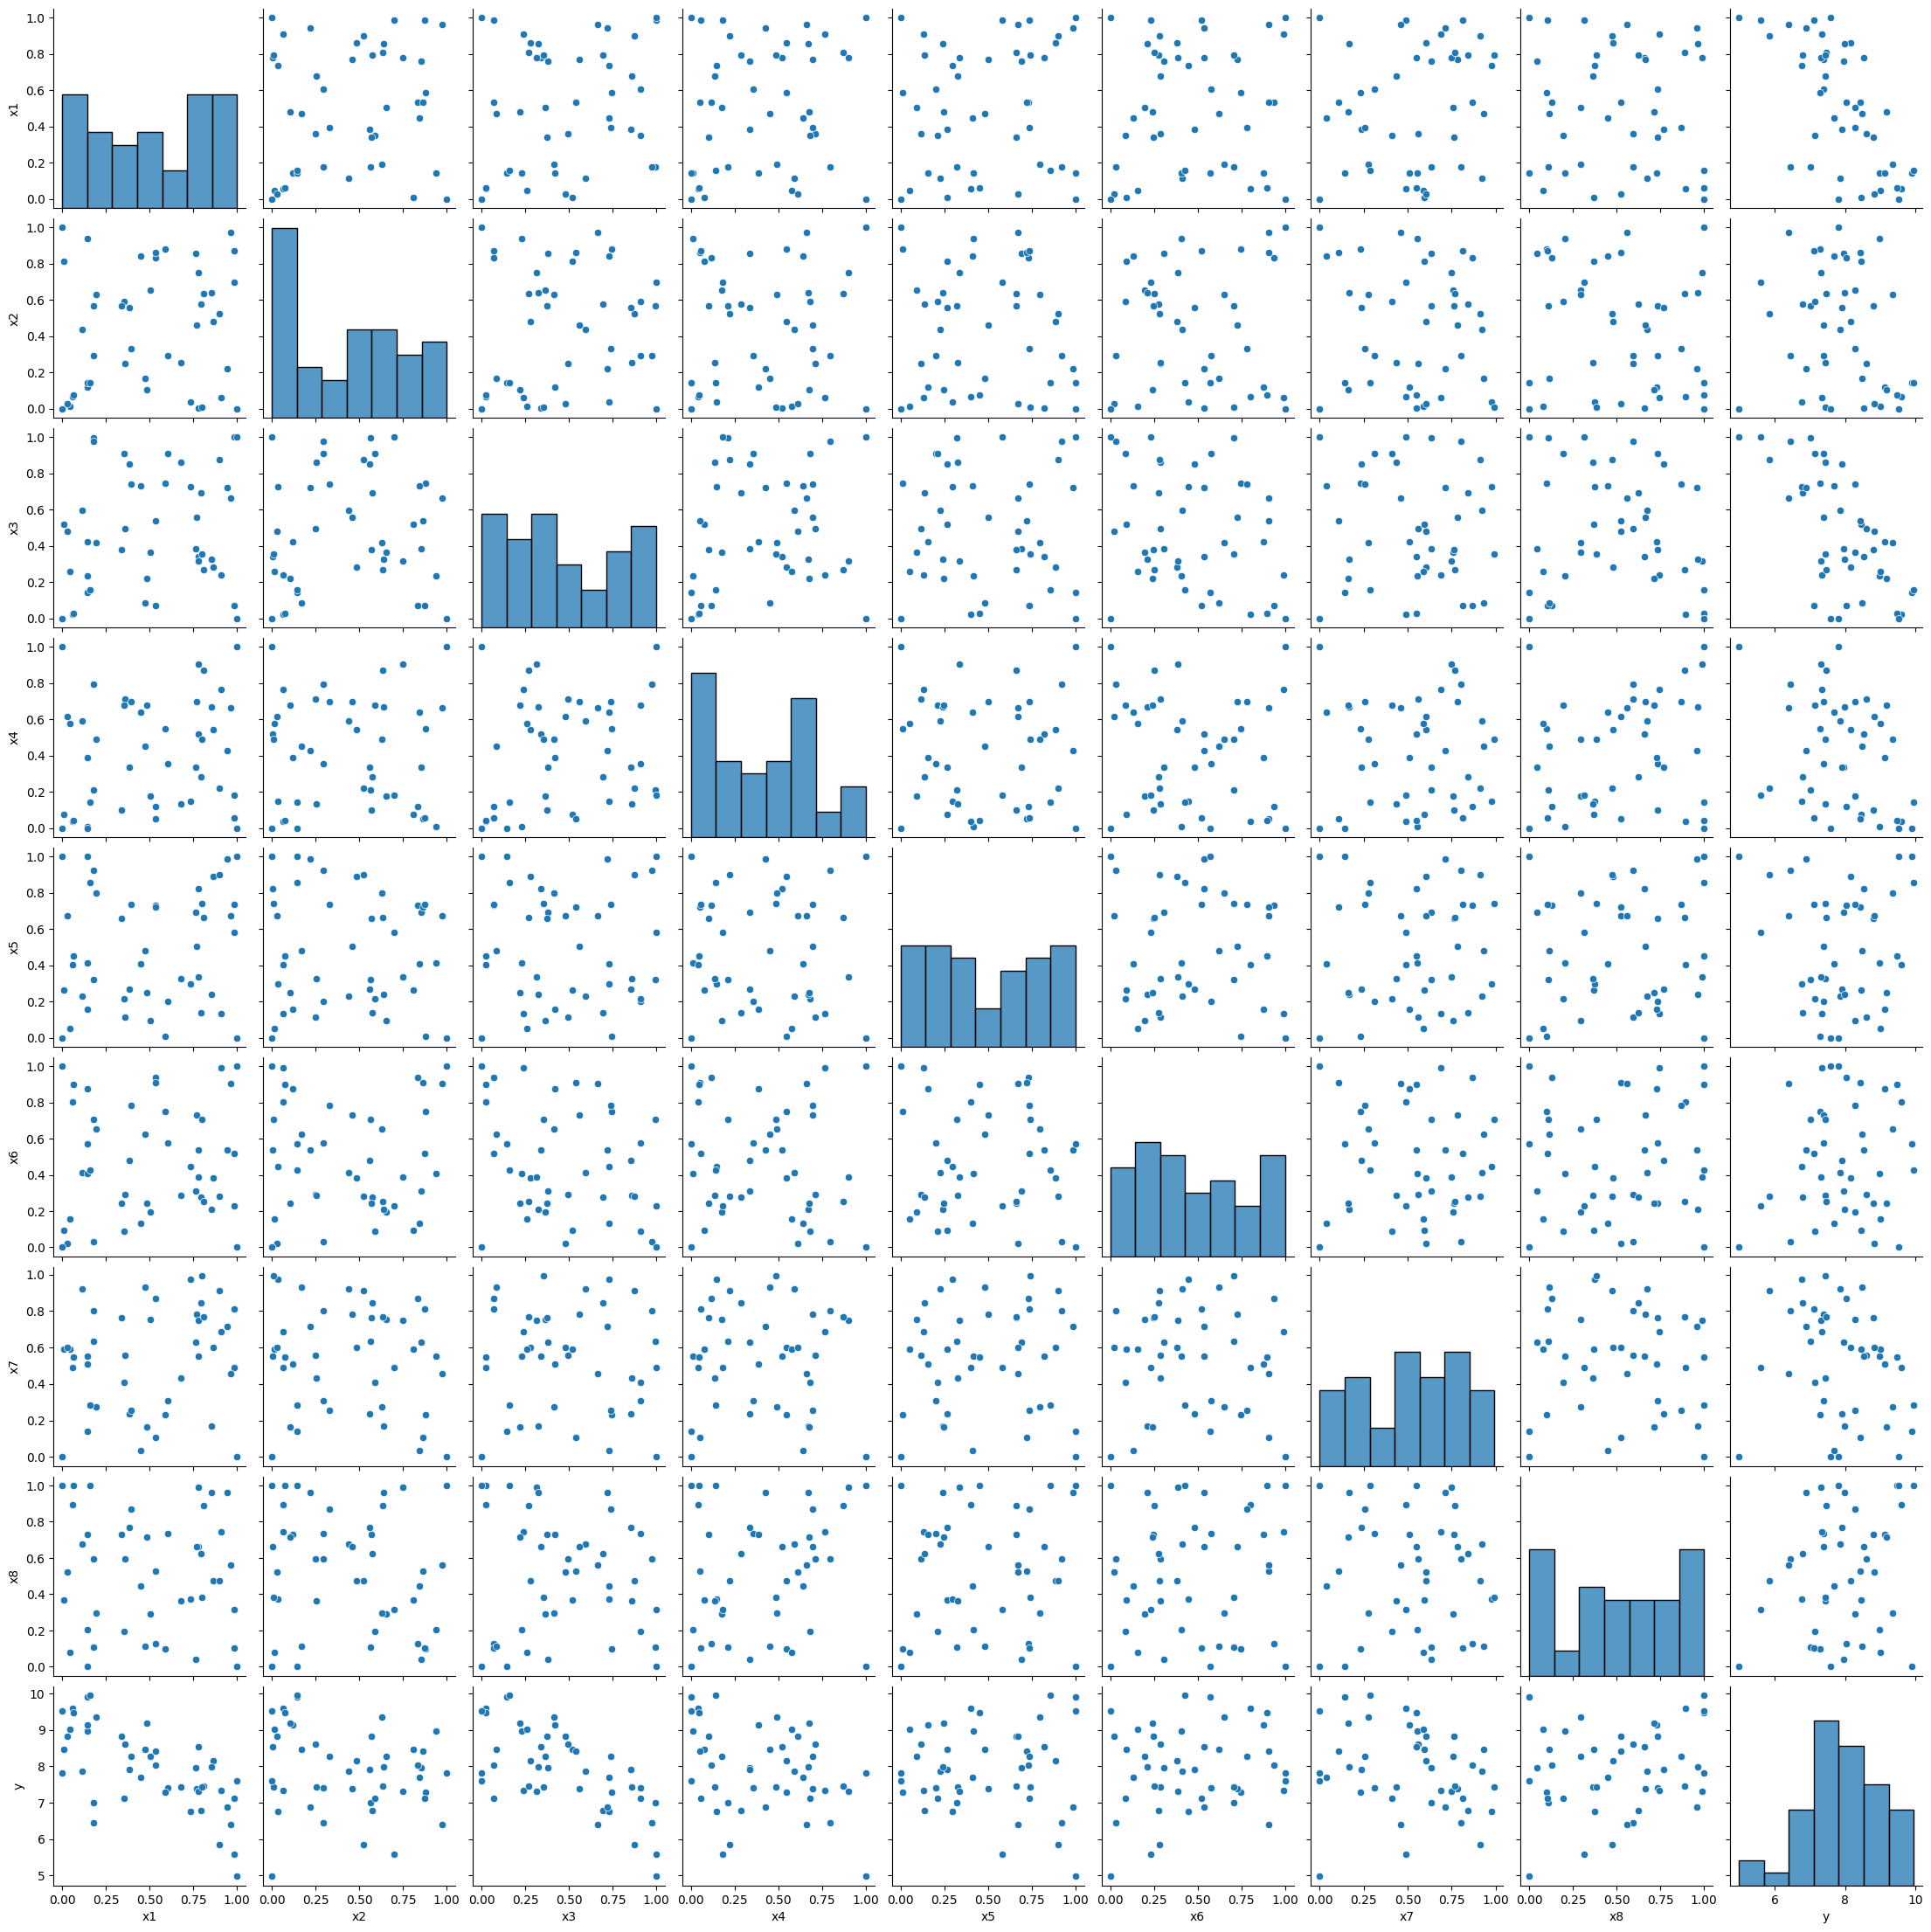

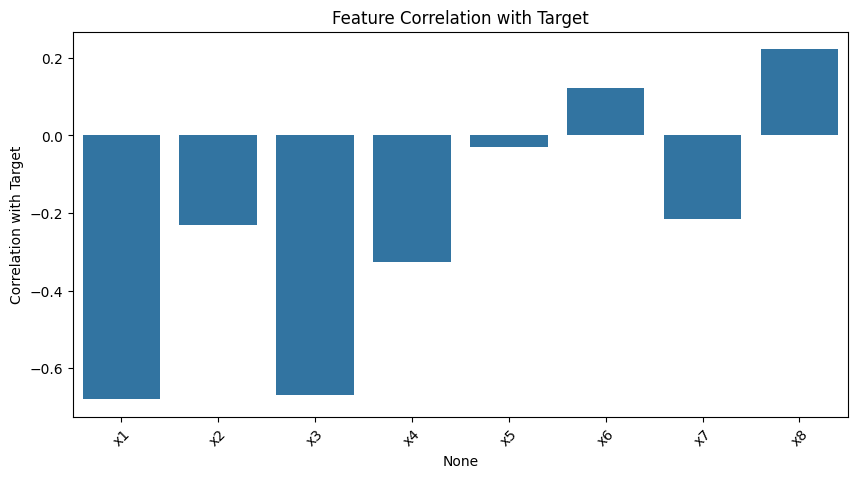

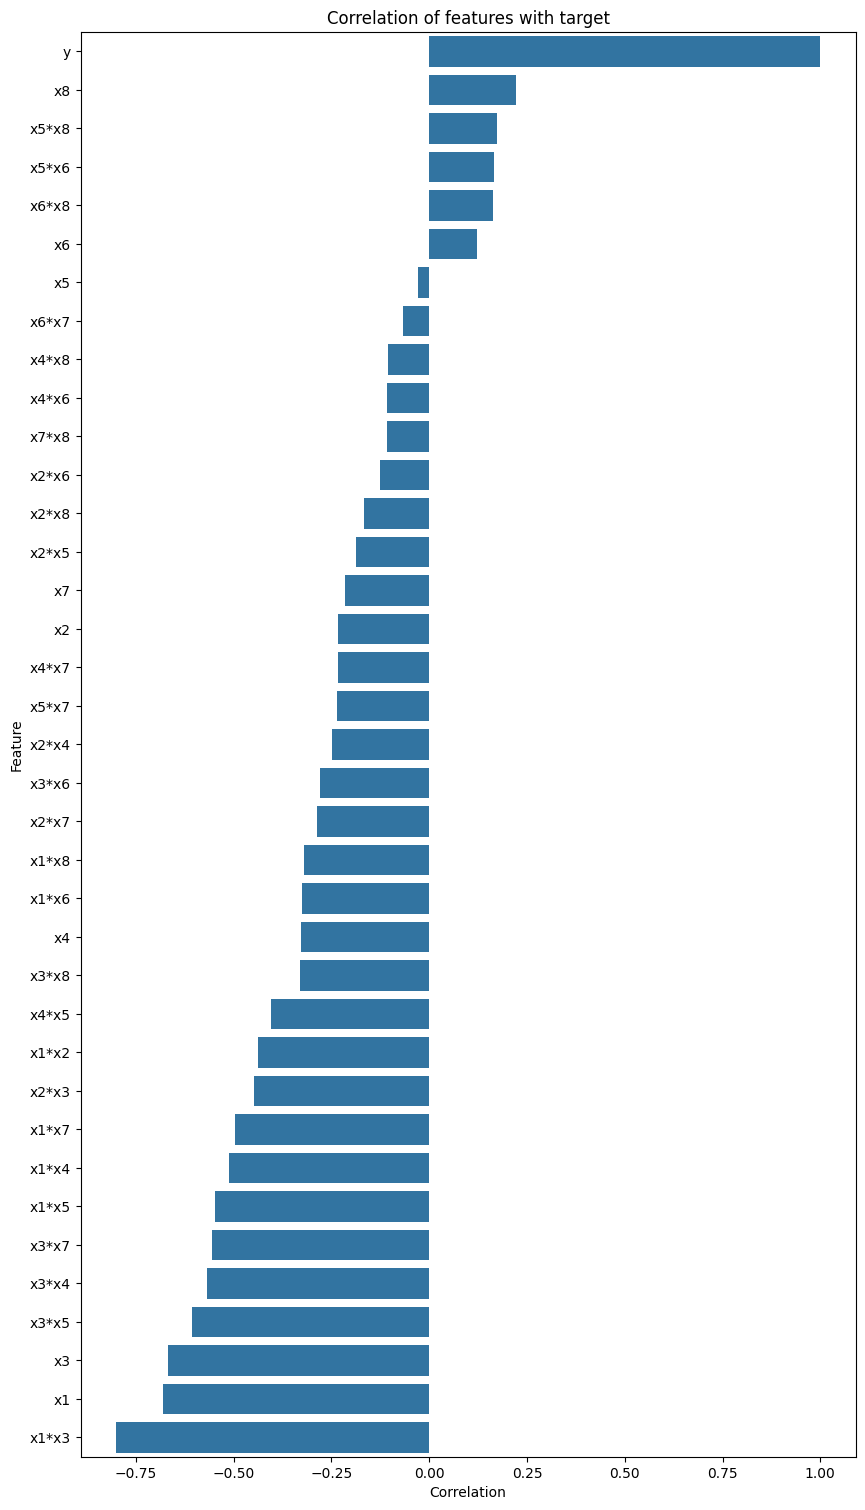

------------ function_8 --------------
       x1     x3      y
0   0.605  0.908  7.399
1   0.178  0.995  7.005
2   0.009  0.521  8.459
3   0.506  0.363  8.284
4   0.360  0.496  8.606
5   0.779  0.338  8.542
6   0.909  0.238  7.327
7   0.586  0.745  7.300
8   0.761  0.382  7.958
9   0.985  0.999  5.592
10  0.112  0.597  7.855
11  0.792  0.695  6.792
12  0.144  0.232  8.977
13  0.770  0.559  7.379
14  0.056  0.023  9.598
15  0.862  0.282  8.160
16  0.352  0.909  7.132
17  0.736  0.728  6.768
18  0.680  0.862  7.434
19  0.044  0.258  9.013
20  0.778  0.314  7.311
21  0.899  0.877  5.841
22  0.145  0.421  9.142
23  0.339  0.377  8.818
24  0.176  0.976  6.452
25  0.029  0.481  8.831
26  0.193  0.417  9.344
27  0.943  0.721  6.888
28  0.533  0.071  8.042
29  0.447  0.730  7.692
30  0.382  0.853  7.924
31  0.533  0.538  8.422
32  0.395  0.741  8.278
33  0.986  0.070  7.113
34  0.965  0.664  6.403
35  0.472  0.086  8.473
36  0.856  0.326  7.978
37  0.810  0.270  7.461
38  0.796  0.356  7.437
3

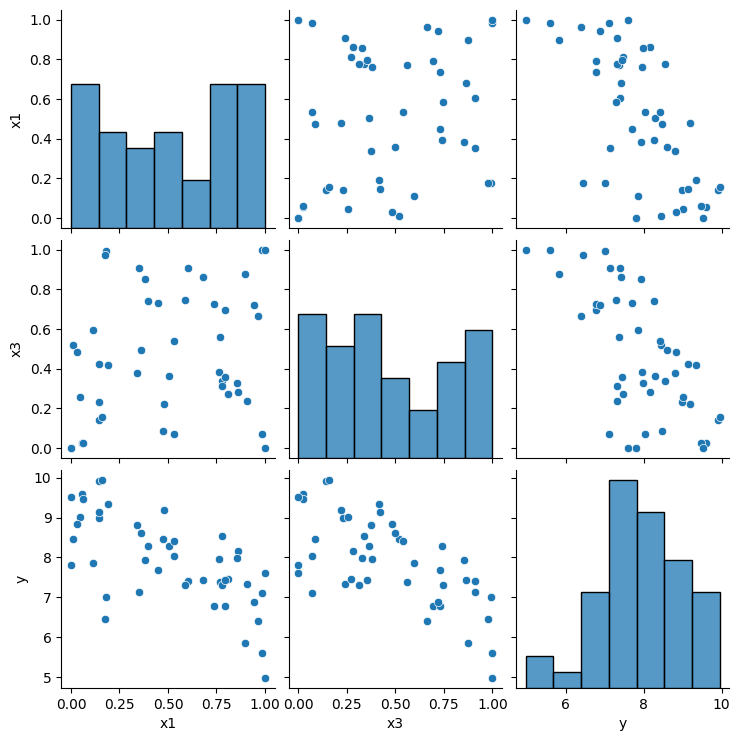

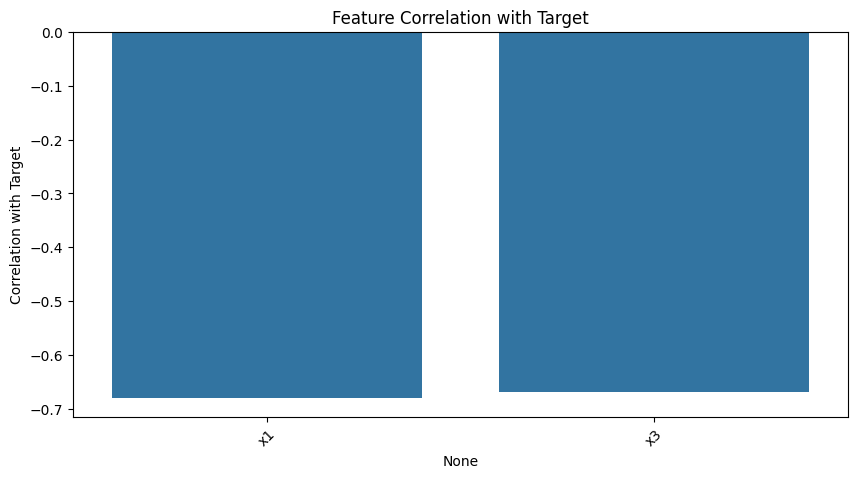

GP kernel=
3.16**2 * Matern(length_scale=[0.2, 0.2], nu=2.5) + WhiteKernel(noise_level=0.1)
Next acquisition point (UCB): [0.15789474 0.15789474]
queryPoint=[0.15789474 0.15789474]
queryPoint (formatted)=0.157895-0.157895


/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning:

The optimal value found for dimension 7 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.



GP kernel=
3.16**2 * Matern(length_scale=[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2], nu=2.5) + WhiteKernel(noise_level=0.1)
Next acquisition point (UCB): [0.14285714 0.14285714 0.14285714 0.14285714 1.         0.
 0.28571429 1.        ]
queryPoint=[0.14285714 0.14285714 0.14285714 0.14285714 1.         0.
 0.28571429 1.        ]
queryPoint (formatted)=0.142857-0.142857-0.142857-0.142857-1.000000-0.000000-0.285714-1.000000


array([0.14285714, 0.14285714, 0.14285714, 0.14285714, 1.        ,
       0.        , 0.28571429, 1.        ])

In [14]:
f8 = BBfcn(8)
print(f8)
f8.plot_feature_correlations()
f8.plot_correlations_with_cross_terms()

f8_dimRed = BBfcn(8)
# dimension reduction for f8()
class f8dimRedTransform(Transformation):
    def __init__(self):
        pass
    def apply(self,data):
        data.drop(columns=["x2","x4","x5","x6","x7","x8"],inplace=True)
f8_dimRed.transform(f8dimRedTransform())
print(f8_dimRed)
f8_dimRed.plot_feature_correlations()
kernel = C(10, (0.001, 100)) * Matern(length_scale=[0.2,0.2],nu=2.5) + WhiteKernel(noise_level=1e-1)
f8_dimRed.nextPointBayesianOptim(kernel,numgrid=20,acqFcn="UCB",beta=0.5)

#full dimensional GP for f8()
kernel = C(10, (0.001, 100)) * Matern(length_scale=[0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2],nu=2.5) + WhiteKernel(noise_level=1e-1)
f8.nextPointBayesianOptim(kernel,numgrid=8,acqFcn="UCB",beta=0)